<a href="https://colab.research.google.com/github/domanmat/OLS_airbnb/blob/main/3_airbnb_prague_apts_no_hosts_xgB_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edycja biblioteki SweetViz
Jeśli chcesz skorzystać z SweetViz - poniżej kod do skutecznego zakomentowania linii w graph_numeric.py:
* za 1-szym razem uruchom tylko komórkę poniżej (bez komentarzy, ctrl+A & ctrl+/)
* zrób to tylko za 1-szym uruchomieniem i tylko tej komórki
* Runtime --> Restart session
* zakomentuj komórkę nr 2 (całą, tral+A & ctrl+/) i puść resztę



In [ ]:
# Inne instalacje które warto wykonać tylko 1 raz - na początku:
!pip install shap -qq
!sudo apt-get install p7zip-full p7zip-rar -qq
!pip install gdown -qq

# Completely remove and reinstall SweetViz
!pip uninstall sweetviz -y -qq
!rm -rf /usr/local/lib/python3.12/dist-packages/sweetviz
!pip install sweetviz -qq

# Now apply the fix with a more robust approach
file_path = '/usr/local/lib/python3.12/dist-packages/sweetviz/graph_numeric.py'

with open(file_path, 'r') as f:
    content = f.read()

# Use string replacement to be precise
old_section = """        gap_percent = config["Graphs"].getfloat("summary_graph_categorical_gap")

        warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
        self.hist_specs = axs.hist(plot_data, weights = normalizing_weights, bins=self.num_bins, \\
                                   rwidth = (100.0 - gap_percent) / 100.0)
        warnings.filterwarnings('once', category=np.VisibleDeprecationWarning)

        bin_limits = self.hist_specs[1]"""

new_section = """        gap_percent = config["Graphs"].getfloat("summary_graph_categorical_gap")

        # warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
        self.hist_specs = axs.hist(plot_data, weights = normalizing_weights, bins=self.num_bins, \\
                                   rwidth = (100.0 - gap_percent) / 100.0)
        # warnings.filterwarnings('once', category=np.VisibleDeprecationWarning)

        bin_limits = self.hist_specs[1]"""

content = content.replace(old_section, new_section)

with open(file_path, 'w') as f:
    f.write(content)

print("✓ File fixed")

# Verify
print("\n=== Lines 69-76 ===")
!sed -n '69,76p' /usr/local/lib/python3.12/dist-packages/sweetviz/graph_numeric.py

# Clear cache
!rm -rf /usr/local/lib/python3.12/dist-packages/sweetviz/__pycache__
!find /usr/local/lib/python3.12/dist-packages/sweetviz -name "*.pyc" -delete

print("\n✓ IMPORTANT: Restart runtime now (Runtime → Restart runtime)")

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package p7zip-rar.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../p7zip-rar_16.02-3build1_amd64.deb ...
Unpacking p7zip-rar (16.02-3build1) ...
Setting up p7zip-rar (16.02-3build1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 115.1 MB/s eta 0:00:00
✓ File fixed

=== Lines 69-76 ===
        gap_percent = config["Graphs"].getfloat("summary_graph_categorical_gap")

        # warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
     

#Stowarzyszenie „Mieszkalnik” rozważa agresywną kampanię inwestycyjną w jednym z europejskich miast, ale potrzebuje Twojej wskazówki, od czego zacząć!

Kontekst: „Mieszkalnik”, stowarzyszenie właścicieli nieruchomości, rozważa agresywną kampanię inwestycyjną w jednym z europejskich miast.

Stowarzyszenie chce wybrać miasto, kierując się dobrą znajomością czynników wpływających na ceny najmu i umiejętnością prognozowania wyników najmu pozyskanych inwestycji.

Cel:
* opracowanie raportu na temat kształtowania się cen najmu Airbnb w wybranych miastach (wykorzystanie technik uczenia maszynowego)
* **rekomendacja miast**, w których Mieszkalnik może rozpocząć inwestycję jako pierwszy (założenie poziomu cen nieruchomości, rozważenie, jakie aspekty podniesienia cen najmu są najlepsze)
* przygotowanie się do przewidywania wyników najmu danej nieruchomości przez Dyrektora ds. Inwestycji Mieszkalnik.

**Odbiorcy:** Rada dyrektorów Mieszkalnik

Źródło danych: http://insideairbnb.com/get-the-data.html



**Zadania programisty:**
* Przygotuj dane (dla 2 miast)
* Załaduj dane do preferowanego narzędzia
* Wykorzystaj model regresji liniowej
* Wykorzystaj modele XGBoost + XAI
* Przekaż wyniki w sposób czytelny reszcie zespołu



Otrzymuje 3780 dolarów za czynsz w wysokości 3800 dolarów – grozi eksmisją
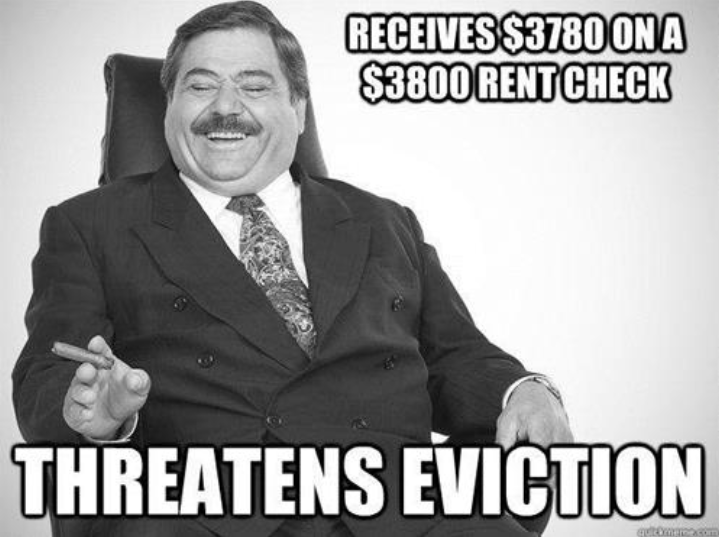


# What shapes Berlin AirBnB prices ?


## Import and load packages

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap

In [ ]:
sns.set_style("whitegrid")

## Airbnb and Airbnb Open Data

**Airbnb** is a company that provides a platform for people to list, discover, and book accommodations around the world. As part of its commitment to transparency and open data, Airbnb has made some of its data available for public use.

The **Airbnb Open Data** initiative provides access to a variety of datasets related to Airbnb's business and the broader hospitality industry. These datasets are made available under an open data license, which allows anyone to access, use, and share the data for any purpose.

The Airbnb Open Data initiative includes a range of datasets, including:

* **Listings data**: This dataset includes information about properties listed on Airbnb, including the location, price, availability, and amenities of each property.

* **Reviews data**: This dataset includes reviews and ratings left by guests who have stayed at Airbnb properties.

* **Calendar data**: This dataset includes availability information for Airbnb properties, including dates when a property is booked or available for booking.

* **Demographic data**: This dataset includes information about the demographics of Airbnb users, including age, gender, and location.

* **Host data**: This dataset includes information about Airbnb hosts, including the properties they own or manage and the number of reviews they have received.

The Airbnb Open Data initiative is intended to help researchers, policymakers, and others better understand the hospitality industry and the impact of Airbnb on communities around the world. It is also intended to encourage the development of new tools, applications, and research that can help Airbnb and other companies improve their services and better meet the needs of their users.

Data is available here http://insideairbnb.com/get-the-data

In this notebook we will focus on **Listings data**  

**Listings data** is a dataset that includes information about properties listed on Airbnb. This dataset includes details about the
* location,
* price,
* availability, and
* amenities of each property.

Here are some examples of the types of information that might be included in the listings data:

* **Property type**: Is the property a private room, shared room, or entire home/apartment?

* **Location**: Where is the property located (e.g., city, state, country)?

* **Price**: How much does it cost to stay at the property?

* **Availability**: When is the property available for booking?

* **Amenities**: What amenities are available at the property (e.g., WiFi, laundry facilities, kitchen)?

* **Photos**: What does the property look like (e.g., interior, exterior)?

Listings data can be useful for understanding the types of properties that are available on Airbnb, as well as the prices and amenities offered. It can also be used to analyze trends in the hospitality industry and understand the demand for different types of accommodations. For example, researchers might use listings data to study the impact of Airbnb on the housing market in a particular city, or to **understand the factors that influence the popularity of different types of properties**.

## Get data

###Download

In [ ]:
# download data for Prague
import gdown
url = 'https://data.insideairbnb.com/czech-republic/prague/prague/2025-09-23/data/listings.csv.gz'

output = "listings_Prague.gz"
gdown.download(url, output)

Downloading...
From: https://data.insideairbnb.com/czech-republic/prague/prague/2025-09-23/data/listings.csv.gz
To: /content/listings_Prague.gz
100%|██████████| 5.58M/5.58M [00:00<00:00, 166MB/s]


'listings_Prague.gz'

In [ ]:
!ls -lah

total 5.4M
drwxr-xr-x 1 root root 4.0K Jan 14 21:25 .
drwxr-xr-x 1 root root 4.0K Jan 14 21:24 ..
drwxr-xr-x 4 root root 4.0K Dec 11 14:34 .config
-rw-r--r-- 1 root root 5.4M Jan 14 21:25 listings_Prague.gz
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data


### Extract files

In [ ]:
# # # Install libraries to unzip all
# !sudo apt-get install p7zip-full p7zip-rar -qq
# Unrar rar file
!7z x {output} -y


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5578702 bytes (5448 KiB)

Extracting archive: listings_Prague.gz
--
Path = listings_Prague.gz
Type = gzip
Headers Size = 23

  0% - listings.csv                   Everything is Ok

Size:       25418816
Compressed: 5578702


In [ ]:
!ls -lah

total 30M
drwxr-xr-x 1 root root 4.0K Jan 14 21:25 .
drwxr-xr-x 1 root root 4.0K Jan 14 21:24 ..
drwxr-xr-x 4 root root 4.0K Dec 11 14:34 .config
-rw-r--r-- 1 root root  25M Nov  7 10:09 listings.csv
-rw-r--r-- 1 root root 5.4M Jan 14 21:25 listings_Prague.gz
drwxr-xr-x 1 root root 4.0K Dec 11 14:34 sample_data


### Read data

In [ ]:
data_raw = pd.read_csv('listings.csv')

In [ ]:
# Print data info
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10834 non-null  int64  
 1   listing_url                                   10834 non-null  object 
 2   scrape_id                                     10834 non-null  int64  
 3   last_scraped                                  10834 non-null  object 
 4   source                                        10834 non-null  object 
 5   name                                          10834 non-null  object 
 6   description                                   10614 non-null  object 
 7   neighborhood_overview                         4458 non-null   object 
 8   picture_url                                   10833 non-null  object 
 9   host_id                                       10834 non-null 

### Raw Data

In [ ]:
# Pokaż wszystkie kolumny i 10 wierszy
pd.set_option('display.max_columns', None)     # Wszystkie kolumny
pd.set_option('display.width', 1000)           # Szerokość wyświetlania
pd.set_option('display.max_colwidth', 50)      # Max szerokość pojedynczej kolumny
pd.set_option('display.expand_frame_repr', False)  # Nie łam DataFrame na wiele linii
pd.set_option('display.max_rows', None)  # Wszystkie wiersze
data_raw.head(100).T

0                                                  1                                                  2                                                  3                                                  4                                                  5                                                  6                                                  7                                                  8                                                  9                                                  10                                                 11                                                 12                                                 13                                                 14                                                 15                                                 16                                                 17                                                 18                                                 19                                                 20                                                 21                                                 22                                                 23                                                 24                                                 25                                                 26                                                 27                                                 28                                                 29                                                 30                                                 31                                                 32                                                 33                                                 34                                                 35                                                 36                                                 37                                                 38                                                 39                                                 40                                                 41                                                 42                                                 43                                                 44                                                 45                                                 46                                                 47                                                 48                                                 49                                                 50                                                 51                                                 52                                                 53                                                 54                                                 55                                                 56                                                 57                                                 58                                                 59                                                 60                                                 61                                                 62                                                 63                                                 64                                                 65                                                 66                                                 67                                                 68                                                 69                                                 70                                                 71                                                 72                                                 73                                                 74                                                 75                                                 76                                                 77                                                 78                    

In [ ]:
data_raw.head(10)

id                         listing_url       scrape_id last_scraped           source                                               name                                        description                              neighborhood_overview                                        picture_url  host_id                                  host_url      host_name  host_since              host_location                                         host_about  host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url host_neighbourhood  host_listings_count  host_total_listings_count  host_verifications host_has_profile_pic host_identity_verified                        neighbourhood neighbourhood_cleansed  neighbourhood_group_cleansed   latitude  longitude              property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities      price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  availability_eoy  number_of_reviews_ly  estimated_occupancy_l365d  estimated_revenue_l365d first_review last_review  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  license instant_bookable  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month
0  23163  https://www.airbnb.com/rooms/23163  20250923203415   2025-09-24  previous scrape                       Residence Karolina - KAROL12  Unique and elegant apartment rental in Prague,...                                                NaN  https://a0.muscache.com/pictures/01bbe32c-3f13...     5282    https://www.airbnb.com/users/show/5282          Klara  2008-12-17            Prague, Czechia  Hello, \r\nglad to see that you are interested...      within an hour               100%                 100%                 t  https://a0.muscache.com/im/pictures/user/b7309...  https://a0.muscache.com/im/pictures/user/b7309...            Josefov                 76.0                       86.0  ['email', 'phone']                    t                      t                                  NaN                Praha 1                           NaN  50.082290   14.41552         Entire rental unit  Entire home/apt             4        NaN         1 bath       1.0   NaN  ["Dishwasher", "Dishes and silverware", "Crib"...        NaN               1             365                     1.0                     1.0                   731.0                   731.0                     1.0                   731.0               NaN                t                0                0                0                 0            2025-09-24                 31                      0                       0                 0                     1                          0                      NaN   2010-09-20  2024-06-15                  4.90                    4.83                       5.00                   5.00                         4.97                    4.93                 4.86      NaN                t                              75                                           74                                             0                                            0               0.17
1  23169  https://www.airbnb.com/rooms/23169  20250923203415   2025-09-24      city scrape                         Residence Masna - Masna302  Masna studio offers a lot of space and privacy...      

In [ ]:
print(data_raw.shape)
data_raw.head()

(10834, 79)


id                         listing_url       scrape_id last_scraped           source                                               name                                        description                              neighborhood_overview                                        picture_url  host_id                                  host_url   host_name  host_since              host_location                                         host_about  host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url host_neighbourhood  host_listings_count  host_total_listings_count  host_verifications host_has_profile_pic host_identity_verified                        neighbourhood neighbourhood_cleansed  neighbourhood_group_cleansed  latitude  longitude              property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities      price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  availability_eoy  number_of_reviews_ly  estimated_occupancy_l365d  estimated_revenue_l365d first_review last_review  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  license instant_bookable  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month
0  23163  https://www.airbnb.com/rooms/23163  20250923203415   2025-09-24  previous scrape                       Residence Karolina - KAROL12  Unique and elegant apartment rental in Prague,...                                                NaN  https://a0.muscache.com/pictures/01bbe32c-3f13...     5282    https://www.airbnb.com/users/show/5282       Klara  2008-12-17            Prague, Czechia  Hello, \r\nglad to see that you are interested...      within an hour               100%                 100%                 t  https://a0.muscache.com/im/pictures/user/b7309...  https://a0.muscache.com/im/pictures/user/b7309...            Josefov                 76.0                       86.0  ['email', 'phone']                    t                      t                                  NaN                Praha 1                           NaN  50.08229   14.41552         Entire rental unit  Entire home/apt             4        NaN         1 bath       1.0   NaN  ["Dishwasher", "Dishes and silverware", "Crib"...        NaN               1             365                     1.0                     1.0                   731.0                   731.0                     1.0                   731.0               NaN                t                0                0                0                 0            2025-09-24                 31                      0                       0                 0                     1                          0                      NaN   2010-09-20  2024-06-15                  4.90                    4.83                       5.00                   5.00                         4.97                    4.93                 4.86      NaN                t                              75                                           74                                             0                                            0               0.17
1  23169  https://www.airbnb.com/rooms/23169  20250923203415   2025-09-24      city scrape                         Residence Masna - Masna302  Masna studio offers a lot of space and privacy...              

### Filter data rows

In [ ]:
# Usuwa wiersze niebędące domami/apartamentami
data_raw = data_raw[data_raw['room_type'] == 'Entire home/apt']

### Filter data columns

In [ ]:
# Usuń wszystkie kolumny zawierające 'host' (case-insensitive)
columns_to_drop = [col for col in data_raw.columns if 'host' in col.lower()]
data_raw = data_raw.drop(columns=columns_to_drop)

print(f"Usunięto {len(columns_to_drop)} kolumn zawierających 'host'")
print(f"Usunięte kolumny: {columns_to_drop}")

Usunięto 22 kolumn zawierających 'host'
Usunięte kolumny: ['host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']


In [ ]:
# Usuń wszystkie kolumny zawierające 'review' (case-insensitive)
columns_to_drop = [col for col in data_raw.columns if 'review' in col.lower()]
data_raw = data_raw.drop(columns=columns_to_drop)

print(f"Usunięto {len(columns_to_drop)} kolumn zawierających 'review'")
print(f"Usunięte kolumny: {columns_to_drop}")

Usunięto 14 kolumn zawierających 'review'
Usunięte kolumny: ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'number_of_reviews_ly', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


# Analysis and Data preparation (EDA with SweetViz)

### Report

In [ ]:
# # Verify the changes
# !ls /usr/local/lib/python3.12/dist-packages/sweetviz/
# !sed -n '69,76p' /usr/local/lib/python3.12/dist-packages/sweetviz/graph_numeric.py

# # Run sweet wiz analysis
# import sweetviz as sv
# import warnings
# warnings.filterwarnings('ignore')

# my_report = sv.analyze(data_raw, pairwise_analysis="off")
# my_report.show_notebook()

In [ ]:
data_raw.head(10)

id                         listing_url       scrape_id last_scraped           source                                               name                                        description                              neighborhood_overview                                        picture_url                        neighbourhood neighbourhood_cleansed  neighbourhood_group_cleansed   latitude  longitude              property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities      price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  availability_eoy  estimated_occupancy_l365d  estimated_revenue_l365d  license instant_bookable
0  23163  https://www.airbnb.com/rooms/23163  20250923203415   2025-09-24  previous scrape                       Residence Karolina - KAROL12  Unique and elegant apartment rental in Prague,...                                                NaN  https://a0.muscache.com/pictures/01bbe32c-3f13...                                  NaN                Praha 1                           NaN  50.082290   14.41552         Entire rental unit  Entire home/apt             4        NaN         1 bath       1.0   NaN  ["Dishwasher", "Dishes and silverware", "Crib"...        NaN               1             365                     1.0                     1.0                   731.0                   731.0                     1.0                   731.0               NaN                t                0                0                0                 0            2025-09-24                 0                          0                      NaN      NaN                t
1  23169  https://www.airbnb.com/rooms/23169  20250923203415   2025-09-24      city scrape                         Residence Masna - Masna302  Masna studio offers a lot of space and privacy...                                                NaN  https://a0.muscache.com/pictures/b450cf2a-8561...                                  NaN                Praha 1                           NaN  50.088300   14.42272         Entire rental unit  Entire home/apt             3        1.0         1 bath       1.0   2.0  ["Dishes and silverware", "Body soap", "Crib",...        NaN               1             365                     1.0                     7.0                     2.0                   731.0                     1.2                   704.6               NaN                t                8               14               14                14            2025-09-24                14                         18                      NaN      NaN                t
2  26755  https://www.airbnb.com/rooms/26755  20250923203415   2025-09-24      city scrape                  Central Prague Old Town Top Floor  Big and beautiful new attic apartment in the v...  This apartment offers a fantastic location. Yo...  https://a0.muscache.com/pictures/miso/Hosting-...  Prague, Hlavní město Praha, Czechia                Praha 1                           NaN  50.087290   14.43179         Entire rental unit  Entire home/apt             4        1.5      1.5 baths       1.0   2.0  ["Fire extinguisher", "Shower gel", "Hot water...  $2,272.00               3             700                     2.0                     5.0                  1125.0                  1125.0                     3.0                  1125.0               NaN                t                1               11               25               142            2025-09-24                25                        255                 579360.0      NaN                f
3  30762  https://www.airbnb.com/rooms/30762  20250923203415   2025-09-24      city scrape                          Residence Rybna - Rybn

# Prepare the target varaible = price
(ma tylko 65% kompletności danych)

### Process data

In [ ]:
# Drop columns with NaNs greater than the threshold
# data = data_raw.dropna(axis=1, thresh= 0.8*data_raw.shape[0]).copy()
data_price = data_raw.dropna(subset=['price']).copy()
# data = data_price.dropna(axis=1, thresh=0.75*data_price.shape[0])
data = data_price.dropna(axis=1, thresh=0.8*data_price.shape[0])
print(len(data))

print(data.shape)
print(data.head(10))

8127
(8127, 38)
       id                         listing_url       scrape_id last_scraped       source                                               name                                        description                                        picture_url neighbourhood_cleansed   latitude  longitude       property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities      price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  availability_eoy  estimated_occupancy_l365d  estimated_revenue_l365d instant_bookable
2   26755  https://www.airbnb.com/rooms/26755  20250923203415   2025-09-24  city scrape                  Central Prague Old Town Top Floor  Big and beautiful new attic apar

### Cloumn names list

In [ ]:
data.head(100).T

2                                                  4                                                  5                                                  6                                                  7                                                  12                                                 13                                                 14                                                 15                                                 16                                                 17                                                 18                                                 19                                                 20                                                 21                                                 22                                                 23                                                 24                                                 25                                                 26                                                 27                                                 28                                                 29                                                 30                                                 32                                                 33                                                 34                                                 36                                                 37                                                 38                                                 39                                                 40                                                 41                                                 45                                                 47                                                 48                                                 49                                                 50                                                 51                                                 52                                                 53                                                 54                                                 56                                                 57                                                 59                                                 60                                                 62                                                 64                                                 65                                                 66                                                 67                                                 69                                                 70                                                 71                                                 72                                                 73                                                 74                                                 75                                                 76                                                 77                                                 78                                                 79                                                 80                                                 81                                                 82                                                 83                                                 84                                                 86                                                 87                                                 88                                                 89                                                 90                                                 91                                                 92                                                 95                                                 96                                                 98                                                 99                                                 100                   

In [ ]:
print(f"Original data shape: {data_raw.shape}")
print(f"Data shape after dropping columns with 'price' NaNs: {data_price.shape}")
print(f"Data shape after dropping columns with NaNs: {data.shape}")

Original data shape: (8973, 43)
Data shape after dropping columns with 'price' NaNs: (8127, 43)
Data shape after dropping columns with NaNs: (8127, 38)


In [ ]:
data.price.head()
# Oups, our price is a string, it has to be cleaned!
# need to clean and convert it to float

2    $2,272.00
4    $2,885.00
5    $2,497.00
6    $2,055.00
7    $1,571.00
Name: price, dtype: object

### Cast the target (price) to float

Cast price column to float (replace "$", "," and cast to "float")

**Price - kwoty podane w CZK przeliczone na EURO!!!**

In [ ]:
# Process
data.price.str.replace("$","").str.replace(",","").astype("float").describe()

# Cast price as float
data.price = data.price.apply(lambda x: x.replace("$", ""))
data.price = data.price.apply(lambda x: x.replace(",", ""))
data.price = data.price.astype("float")

# Przekształć liniowo: price/100*4.11 - kurs 100 koron = 4,11 eur
data.price = data.price / 100 * 4.11

data.price.describe()

/tmp/ipython-input-2462309413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.price = data.price.apply(lambda x: x.replace("$", ""))
/tmp/ipython-input-2462309413.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.price = data.price.apply(lambda x: x.replace(",", ""))
/tmp/ipython-input-2462309413.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

count    8127.000000
mean      170.832552
std       666.690084
min        13.028700
25%        68.431500
50%        92.927100
75%       136.061550
max      9974.559000
Name: price, dtype: float64

### Outlier deletion

LIKWIDACJA OUTLIERÓW, po co?

Słabo modelują dane.

Odcięcie 99, 98, 95 percentyla - ok.
Podobnie odcięcie 1,2,5 percentyla.

In [ ]:
data.price.describe()

count    8127.000000
mean      170.832552
std       666.690084
min        13.028700
25%        68.431500
50%        92.927100
75%       136.061550
max      9974.559000
Name: price, dtype: float64

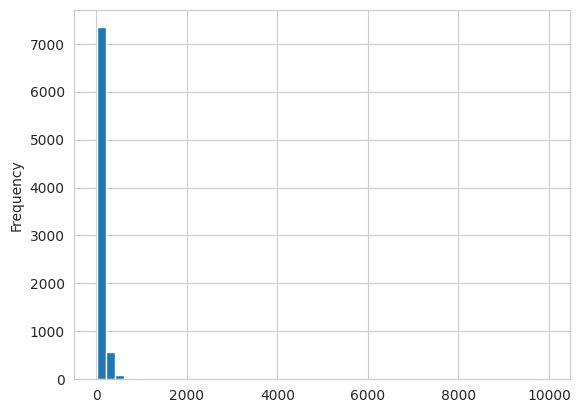

In [ ]:
# Mhm, we have outliers which seem to be to-be-deleted-errors
data.price.plot.hist(bins=50)
plt.show()

In [ ]:
# Getting rid of outliers
threshold_top=(np.percentile(data.price, 95))
threshold_bottom=(np.percentile(data.price, 5))
print("95% properties have a price lower than {0: .2f}".format(threshold_top))
print("95% properties have a price higher than {0: .2f}".format(threshold_bottom))
data_cut = data[(data.price <= threshold_top) & (data.price > threshold_bottom)]
all_data=data
data = data_cut
print(all_data.shape, data.shape)

95% properties have a price lower than  297.85
95% properties have a price higher than  47.59
(8127, 38) (7312, 38)


<Axes: ylabel='Frequency'>

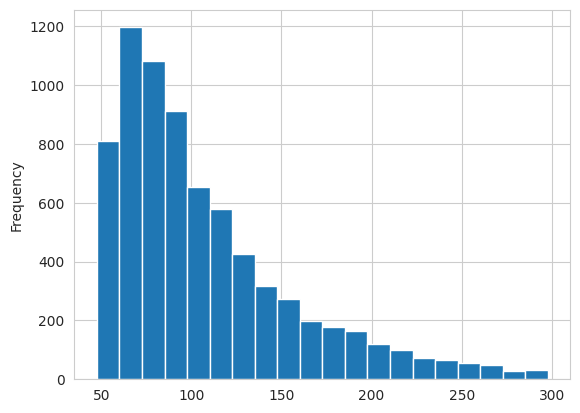

In [ ]:
all_data.query(f'price > {threshold_bottom} & price < {threshold_top}').price.plot.hist(bins=20)

# DANE DO MODELU = X


## Braki
Zastąpienie brakujących danych:
* dane numeryczne - zastąpienie średnią
* dane kategoryczne - zastąpienie najczęściej występującą



In [ ]:
# from sklearn.impute import SimpleImputer

# numeric_cols     = X_train.select_dtypes(include=['number']).columns
# categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# numeric_imputer     = SimpleImputer(strategy='mean')
# categorical_imputer = SimpleImputer(strategy='most_frequent')

# # Apply imputer to numeric columns
# X_train[numeric_cols]     = numeric_imputer.fit_transform(X_train[numeric_cols])
# X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

# # Apply imputer to numeric columns
# X_test[numeric_cols]     = numeric_imputer.transform(X_test[numeric_cols])
# X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])


In [ ]:
# X_train.shape, X_test.shape
# # ((5849, 39), (1463, 39)) przy zastępowaniu braków

In [ ]:
# Usuń wiersze z brakującymi danymi
data = data.dropna()

# Opcjonalnie - wyświetl informacje o usuniętych wierszach
print(f"Rozmiar data po usunięciu braków: {data.shape}")

Rozmiar data po usunięciu braków: (7151, 38)


## Create New Features


### New Variable - Lokalizacja względem innych Airbnb
Średnia z jednej i drugiej współrzędnej powinna dać centrum.

Ale nie musi, może lepiej dać centrum Berlina?

In [ ]:
# data['lat_dist_mean']  = data['latitude'].apply(lambda x: (x-np.mean( data['latitude']))**2)
# data['lon_dist_mean']  = data['longitude'].apply(lambda x: (x-np.mean( data['longitude']))**2)

lat_mean = data['latitude'].mean()
lon_mean = data['longitude'].mean()

data['lat_dist_mean'] = (data['latitude'] - lat_mean) ** 2
data['lon_dist_mean'] = (data['longitude'] - lon_mean) ** 2


/tmp/ipython-input-2658343890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lat_dist_mean'] = (data['latitude'] - lat_mean) ** 2
/tmp/ipython-input-2658343890.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lon_dist_mean'] = (data['longitude'] - lon_mean) ** 2


### New Variable - Distance from city centre
odległość od średniej z odległości ze współrzędnych

to nie jest odległość od centrum berlina - odległość od centrum powinna być lepsza - zmienić

In [ ]:
# Punkt referencyjny - Praski zegar astronomiczny
ref_lat = 50.087101535185525
ref_lon = 14.420685907440566

# Obliczanie kwadratu odległości od punktu referencyjnego
data['lat_dist_center'] = (data['latitude'] - ref_lat) ** 2
data['lon_dist_center'] = (data['longitude'] - ref_lon) ** 2

# Opcjonalnie: rzeczywista odległość euklidesowa
data['dist_from_center'] = np.sqrt(data['lat_dist_center'] + data['lon_dist_center'])

/tmp/ipython-input-2537087514.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lat_dist_center'] = (data['latitude'] - ref_lat) ** 2
/tmp/ipython-input-2537087514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lon_dist_center'] = (data['longitude'] - ref_lon) ** 2
/tmp/ipython-input-2537087514.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

### New Variable - Neighbourhood

one (???) encoding - kodowanie do zmiennej numerycznej, jak to się robi

In [ ]:
top_n = 20
data['neighbourhood_cleansed'].value_counts().nlargest(top_n).to_dict()

{'Praha 1': 2638,
 'Praha 2': 1299,
 'Praha 3': 764,
 'Praha 5': 654,
 'Praha 8': 444,
 'Praha 7': 310,
 'Praha 10': 237,
 'Praha 4': 217,
 'Praha 6': 210,
 'Praha 9': 93,
 'Praha 13': 40,
 'Velká Chuchle': 25,
 'Praha 11': 22,
 'Praha 14': 21,
 'Praha 12': 18,
 'Libuš': 16,
 'Praha 15': 14,
 'Praha 18': 11,
 'Zličín': 10,
 'Zbraslav': 9}

In [ ]:
top_nbhds = list(data['neighbourhood_cleansed'].value_counts().nlargest(top_n).index)
data['neighbourhood_cleansed_map'] = data['neighbourhood_cleansed'].apply(lambda x: x if x in top_nbhds else 'other')

stats = data.groupby('neighbourhood_cleansed_map')['price'].agg([
    'count',
    'mean',
    'median'
]).sort_values('mean', ascending=False)

# Dodaj wiersz "ALL" na końcu
stats.loc['─' * 20] = ['', '', '']  # separator
stats.loc['ALL (Total)'] = [
    data['price'].count(),
    data['price'].mean(),
    data['price'].median()
]

stats['mean'] = stats['mean'].round(2)
stats


/tmp/ipython-input-2750755254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['neighbourhood_cleansed_map'] = data['neighbourhood_cleansed'].apply(lambda x: x if x in top_nbhds else 'other')


count        mean     median
neighbourhood_cleansed_map                               
Libuš                           16  127.908338   101.8047
Praha 1                       2638  125.048729  111.64815
Praha 18                        11  114.796036     102.75
Praha 13                        40  105.034133    93.3381
Praha 7                        310  104.813485    90.7488
Praha 2                       1299  104.169738    92.5572
Praha 5                        654   101.50418   86.57715
other                           99  101.457218    86.1456
Praha 8                        444   95.368292    84.1728
Zbraslav                         9   94.835967    72.4182
Praha 6                        210    94.22449    79.6929
Velká Chuchle                   25   93.925008    95.4753
Zličín                          10    93.88473     92.064
Praha 10                       237   91.509584    75.7473
Praha 9                         93   90.739961    76.3227
Praha 12                        18    90.28985    69.3357
Praha 3                        764   89.158596   73.91835
Praha 14                        21   88.500043    73.4046
Praha 11                        22   87.750368    77.3091
Praha 4                        217   86.674407    78.3366
Praha 15                        14   81.697993      73.98
────────────────────                                     
ALL (Total)                 7151.0  107.888006    93.1737

In [ ]:
data[data['neighbourhood_cleansed_map'] != 'other']['neighbourhood_cleansed_map'].head(10)


2     Praha 1
4     Praha 1
5     Praha 2
6     Praha 2
7     Praha 1
12    Praha 1
13    Praha 1
14    Praha 1
15    Praha 1
17    Praha 3
Name: neighbourhood_cleansed_map, dtype: object

### Parsowanie amenities

In [ ]:
import ast
from collections import Counter

data_amenities = data.copy()

# Jeśli wartości są stringami reprezentującymi listy
data_amenities['amenities_parsed'] = data['amenities'].apply(ast.literal_eval)

# Rozwiń wszystkie amenities do pojedynczych wierszy
amenities_expanded = data_amenities.explode('amenities_parsed')

# Podstawowe statystyki
print("Najczęstsze udogodnienia:")
print(amenities_expanded['amenities_parsed'].value_counts().head(10))

Najczęstsze udogodnienia:
amenities_parsed
Kitchen                  6754
Hot water                6460
Hair dryer               6438
Wifi                     6418
Dishes and silverware    6207
Hangers                  6095
Bed linens               6070
Cooking basics           5998
Essentials               5725
Iron                     5694
Name: count, dtype: int64


In [ ]:
amenity_counts = Counter()
for amenities in data_amenities['amenities_parsed']:
    amenity_counts.update(amenities)

# Całkowita liczba wierszy
total_rows = len(data_amenities)

# Filtrowanie amenities występujących w >10% wierszy
amenities_used = [
    amenity for amenity, count in amenity_counts.items()
    if (count / total_rows) > 0.10
]

# Wyświetlenie wyników
print(f"Liczba amenities występujących w >10% wierszy: {len(amenities_used)}")
print(f"\nLista amenities_used:")
for amenity in sorted(amenities_used):
    count = amenity_counts[amenity]
    percentage = (count / total_rows) * 100
    print(f"  {amenity}: {count}/{total_rows} ({percentage:.1f}%)")

Liczba amenities występujących w >10% wierszy: 70

Lista amenities_used:
  Air conditioning: 1020/7151 (14.3%)
  Baking sheet: 2004/7151 (28.0%)
  Bathtub: 1746/7151 (24.4%)
  Bed linens: 6070/7151 (84.9%)
  Body soap: 3310/7151 (46.3%)
  Books and reading material: 864/7151 (12.1%)
  Carbon monoxide alarm: 2737/7151 (38.3%)
  Central heating: 2009/7151 (28.1%)
  Cleaning products: 3569/7151 (49.9%)
  Clothing storage: 2125/7151 (29.7%)
  Clothing storage: closet: 1240/7151 (17.3%)
  Coffee: 3310/7151 (46.3%)
  Coffee maker: 2490/7151 (34.8%)
  Coffee maker: Nespresso: 936/7151 (13.1%)
  Conditioner: 1010/7151 (14.1%)
  Cooking basics: 5998/7151 (83.9%)
  Crib: 1491/7151 (20.9%)
  Dedicated workspace: 3952/7151 (55.3%)
  Dining table: 4643/7151 (64.9%)
  Dishes and silverware: 6207/7151 (86.8%)
  Dishwasher: 3804/7151 (53.2%)
  Dryer: 727/7151 (10.2%)
  Drying rack for clothing: 3203/7151 (44.8%)
  Elevator: 3896/7151 (54.5%)
  Essentials: 5725/7151 (80.1%)
  Ethernet connection: 899/7

### New Variable - Amenities - udogodnienia
lista tego, co się znajduje w każdym mieszkaniu, lista która jest dość długa.


In [ ]:
# ### OLD
# # Create some features
# data['is_wifi']        = data['amenities'].apply(lambda x: 'wifi' in x.lower())*1
# data['is_tv']          = data['amenities'].apply(lambda x: 'tv' in x.lower())*1
# data['is_essentials']  = data['amenities'].apply(lambda x: 'essentials' in x.lower())*1
# data['n_amenities']    = data['amenities'].apply(lambda x: len(x.split(',')))

In [ ]:
data=data.copy()
data['n_amenities'] = data['amenities'].apply(lambda x: len(x.split(',')))

# Parsowanie kolumny amenities jeśli jeszcze nie jest listą
if data['amenities'].dtype == 'object' and isinstance(data['amenities'].iloc[0], str):
    import ast
    data['amenities_parsed'] = data['amenities'].apply(ast.literal_eval)
else:
    data['amenities_parsed'] = data['amenities']

# Tworzenie binarnych kolumn dla każdego amenity z listy amenities_used
for amenity in amenities_used:
    column_name = f"is_{amenity.lower().replace(' ', '_').replace('\u2019', '').replace('-', '_').replace(':', '').replace('/', '_').replace('-', '_').replace('–', '_')}"
    data[column_name] = data['amenities_parsed'].apply(
        lambda x: 1 if amenity in x else 0
    )

print(f"Dodano {len(amenities_used)} nowych kolumn binarnych")
data.head(3)

Dodano 70 nowych kolumn binarnych


id                         listing_url       scrape_id last_scraped       source                                               name                                        description                                        picture_url neighbourhood_cleansed  latitude  longitude       property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities     price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  availability_eoy  estimated_occupancy_l365d  estimated_revenue_l365d instant_bookable  lat_dist_mean  lon_dist_mean  lat_dist_center  lon_dist_center  dist_from_center neighbourhood_cleansed_map  n_amenities                                   amenities_parsed  is_fire_extinguisher  is_shower_gel  is_hot_water_kettle  is_dishwasher  is_dishes_and_silverware  is_body_soap  is_extra_pillows_and_blankets  is_cooking_basics  is_elevator  is_microwave  is_conditioner  is_freezer  is_cleaning_products  is_self_check_in  is_coffee  is_free_washer___in_unit  is_carbon_monoxide_alarm  is_essentials  is_refrigerator  is_long_term_stays_allowed  is_luggage_dropoff_allowed  is_first_aid_kit  is_wine_glasses  is_coffee_maker  is_clothing_storage_closet  is_iron  is_dining_table  is_books_and_reading_material  is_bed_linens  is_hot_water  is_central_heating  is_smoke_alarm  is_paid_parking_off_premises  is_bathtub  is_hair_dryer  is_private_entrance  is_toaster  is_single_level_home  is_hangers  is_room_darkening_shades  is_wifi  is_drying_rack_for_clothing  is_shampoo  is_kitchen  is_ethernet_connection  is_heating  is_stove  is_washer  is_dryer  is_dedicated_workspace  is_host_greets_you  is_oven  is_pack_n_play_travel_crib  is_lockbox  is_pets_allowed  is_tv  is_clothing_storage  is_portable_fans  is_paid_street_parking_off_premises  is_high_chair  is_exterior_security_cameras_on_property  is_laundromat_nearby  is_outdoor_furniture  is_crib  is_mini_fridge  is_air_conditioning  is_paid_parking_on_premises  is_baking_sheet  is_private_patio_or_balcony  is_coffee_maker_nespresso
2  26755  https://www.airbnb.com/rooms/26755  20250923203415   2025-09-24  city scrape                  Central Prague Old Town Top Floor  Big and beautiful new attic apartment in the v...  https://a0.muscache.com/pictures/miso/Hosting-...                Praha 1  50.08729   14.43179  Entire rental unit  Entire home/apt             4        1.5      1.5 baths       1.0   2.0  ["Fire extinguisher", "Shower gel", "Hot water...   93.3792               3             700                     2.0                     5.0                  1125.0                  1125.0                     3.0                  1125.0                t                1               11               25               142            2025-09-24                25                        255                 579360.0                f       0.000038       0.000003     3.551899e-08         0.000123          0.011106                    Praha 1           58  [Fire extinguisher, Shower gel, Hot water kett...                     1              1                    1              1                         1             1                              1                  1            1             1               1           1                     1                 1          1                         1                         1              1                1                           1                           1                 1                1                1                           1        1                1                              1              1             1                   1               1                             1           1              1                    1           1          

### New Variable - Property_type

In [ ]:
top_n = 6
data['property_type'].value_counts().nlargest(top_n).to_dict()

{'Entire rental unit': 5219,
 'Entire condo': 810,
 'Entire serviced apartment': 758,
 'Entire loft': 103,
 'Entire home': 97,
 'Entire guest suite': 39}

In [ ]:
top_pr_type = list(data['property_type'].value_counts().nlargest(top_n).index)
data['property_type_map'] = data['property_type'].apply(lambda x: x if x in top_pr_type else 'other')
data['property_type_map'].head(3)

2    Entire rental unit
4    Entire rental unit
5    Entire rental unit
Name: property_type_map, dtype: object

In [ ]:
# data.replace({'host_is_superhost' : {'t' : 1, 'f' : 0}}, inplace=True)
data.replace({'instant_bookable' : {'t' : 1, 'f' : 0}}, inplace=True)

/tmp/ipython-input-41485973.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'instant_bookable' : {'t' : 1, 'f' : 0}}, inplace=True)


### Numerical columns

In [ ]:
# get all numeric - just string creation
all_num_feats = [x for x in data.dtypes[data.dtypes != 'object'].index if not ('id' in x)
and not ('url' in x) and not ('price' in x)
and not ('longitude' in x) and not ('latitude' in x) ]

# print numerical featuresa
print(" \n + ".join(all_num_feats))

accommodates 
 + bathrooms 
 + bedrooms 
 + beds 
 + minimum_nights 
 + maximum_nights 
 + minimum_minimum_nights 
 + maximum_minimum_nights 
 + minimum_maximum_nights 
 + maximum_maximum_nights 
 + minimum_nights_avg_ntm 
 + maximum_nights_avg_ntm 
 + availability_30 
 + availability_60 
 + availability_90 
 + availability_365 
 + availability_eoy 
 + estimated_occupancy_l365d 
 + estimated_revenue_l365d 
 + instant_bookable 
 + lat_dist_mean 
 + lon_dist_mean 
 + lat_dist_center 
 + lon_dist_center 
 + dist_from_center 
 + n_amenities 
 + is_fire_extinguisher 
 + is_shower_gel 
 + is_hot_water_kettle 
 + is_dishwasher 
 + is_dishes_and_silverware 
 + is_body_soap 
 + is_extra_pillows_and_blankets 
 + is_cooking_basics 
 + is_elevator 
 + is_microwave 
 + is_conditioner 
 + is_freezer 
 + is_cleaning_products 
 + is_self_check_in 
 + is_coffee 
 + is_free_washer___in_unit 
 + is_essentials 
 + is_refrigerator 
 + is_long_term_stays_allowed 
 + is_luggage_dropoff_allowed 
 + is_wine_gl

### Categorical columns

In [ ]:
# get all categorical - just string creation
all_cat_feats = [x for x in data.dtypes[data.dtypes == 'object'].index if not ('id' in x) and not ('url' in x) and not ('price' in x) ]

# print numerical features
print(" \n + ".join(all_cat_feats))

last_scraped 
 + source 
 + name 
 + description 
 + neighbourhood_cleansed 
 + property_type 
 + room_type 
 + bathrooms_text 
 + amenities 
 + has_availability 
 + calendar_last_scraped 
 + neighbourhood_cleansed_map 
 + amenities_parsed 
 + property_type_map


# Logarytmowanie danych (price)
Log "ściska" duże wartości i "rozciąga" małe, co normalizuje rozkład.
* Normalizuje rozkład - skośny → symetryczny
* Redukuje heteroskedastyczność - stała wariancja
* Zmniejsza wpływ outlierów - ekstremalne wartości mniej ważne
* Lepsze predykcje - zwłaszcza dla dużych wartości
* ! Zmienia interpretację - współczynniki = % zmiana, nie €
* ! Wymaga odwrotnej transformacji - exp() dla predykcji

<Axes: >

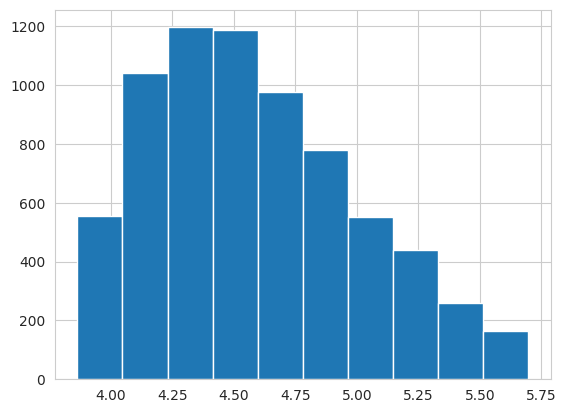

In [ ]:
# Possible consideration - logarithm transformation - can help to get better fit??
data['log_price'] = data.price.apply(np.log)
data['log2_price'] = data.log_price.apply(np.log)
data['log3_price'] = data.log2_price.apply(np.log)
data['log4_price'] = data.log3_price.apply(np.log)
data['log5_price'] = data.log4_price.apply(np.log)
data['sqrt_price'] = data.price.apply(np.sqrt)

data.log_price.hist()

# Kodowanie zmiennych kategorycznych do numerycznych
one-hot encoding - po to by móc zrobić SHAP i xgBoost (tylko numeryczne przyjmuje)

In [ ]:
# Zakoduj zmienne kategoryczne
data_encoded = data.copy()

# Konwertuj wszystkie boolean na int
bool_cols = data_encoded.select_dtypes(include='bool').columns
data_encoded[bool_cols] = data_encoded[bool_cols].astype(int)

# One-hot encoding dla zmiennych kategorycznych
categorical_cols = ['property_type_map', 'neighbourhood_cleansed_map']

for col in categorical_cols:
    if col in data_encoded.columns:
        dummies = pd.get_dummies(data_encoded[col], prefix=col, drop_first=True, dtype=int)
        # Zamień spacje na podkreślenia w nazwach dummy columns
        dummies.columns = dummies.columns.str.replace(' ', '_')
        data_encoded = pd.concat([data_encoded.drop(col, axis=1), dummies], axis=1)

# Zamień spacje na podkreślenia we wszystkich nazwach kolumn (na wszelki wypadek)
data_encoded.columns = data_encoded.columns.str.replace(' ', '_')

data_encoded.head(10)

id                          listing_url       scrape_id last_scraped       source                                               name                                        description                                        picture_url neighbourhood_cleansed   latitude  longitude       property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities     price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  availability_eoy  estimated_occupancy_l365d  estimated_revenue_l365d  instant_bookable  lat_dist_mean  lon_dist_mean  lat_dist_center  lon_dist_center  dist_from_center  n_amenities                                   amenities_parsed  is_fire_extinguisher  is_shower_gel  is_hot_water_kettle  is_dishwasher  is_dishes_and_silverware  is_body_soap  is_extra_pillows_and_blankets  is_cooking_basics  is_elevator  is_microwave  is_conditioner  is_freezer  is_cleaning_products  is_self_check_in  is_coffee  is_free_washer___in_unit  is_carbon_monoxide_alarm  is_essentials  is_refrigerator  is_long_term_stays_allowed  is_luggage_dropoff_allowed  is_first_aid_kit  is_wine_glasses  is_coffee_maker  is_clothing_storage_closet  is_iron  is_dining_table  is_books_and_reading_material  is_bed_linens  is_hot_water  is_central_heating  is_smoke_alarm  is_paid_parking_off_premises  is_bathtub  is_hair_dryer  is_private_entrance  is_toaster  is_single_level_home  is_hangers  is_room_darkening_shades  is_wifi  is_drying_rack_for_clothing  is_shampoo  is_kitchen  is_ethernet_connection  is_heating  is_stove  is_washer  is_dryer  is_dedicated_workspace  is_host_greets_you  is_oven  is_pack_n_play_travel_crib  is_lockbox  is_pets_allowed  is_tv  is_clothing_storage  is_portable_fans  is_paid_street_parking_off_premises  is_high_chair  is_exterior_security_cameras_on_property  is_laundromat_nearby  is_outdoor_furniture  is_crib  is_mini_fridge  is_air_conditioning  is_paid_parking_on_premises  is_baking_sheet  is_private_patio_or_balcony  is_coffee_maker_nespresso  log_price  log2_price  log3_price  log4_price  log5_price  sqrt_price  property_type_map_Entire_guest_suite  property_type_map_Entire_home  property_type_map_Entire_loft  property_type_map_Entire_rental_unit  property_type_map_Entire_serviced_apartment  property_type_map_other  neighbourhood_cleansed_map_Praha_1  neighbourhood_cleansed_map_Praha_10  neighbourhood_cleansed_map_Praha_11  neighbourhood_cleansed_map_Praha_12  neighbourhood_cleansed_map_Praha_13  neighbourhood_cleansed_map_Praha_14  neighbourhood_cleansed_map_Praha_15  neighbourhood_cleansed_map_Praha_18  neighbourhood_cleansed_map_Praha_2  neighbourhood_cleansed_map_Praha_3  neighbourhood_cleansed_map_Praha_4  neighbourhood_cleansed_map_Praha_5  neighbourhood_cleansed_map_Praha_6  neighbourhood_cleansed_map_Praha_7  neighbourhood_cleansed_map_Praha_8  neighbourhood_cleansed_map_Praha_9  neighbourhood_cleansed_map_Velká_Chuchle  neighbourhood_cleansed_map_Zbraslav  neighbourhood_cleansed_map_Zličín  neighbourhood_cleansed_map_other
2    26755   https://www.airbnb.com/rooms/26755  20250923203415   2025-09-24  city scrape                  Central Prague Old Town Top Floor  Big and beautiful new attic apartment in the v...  https://a0.muscache.com/pictures/miso/Hosting-...                Praha 1  50.087290   14.43179  Entire rental unit  Entire home/apt             4        1.5      1.5 baths       1.0   2.0  ["Fire extinguisher", "Shower gel", "Hot water...   93.3792               3             700                     2.0                     5.0                  1125.0                  1125.0                     3.0                  1125.0                t                1               11               25               142   

## Numerical columns

In [ ]:
# get all numeric - just string creation
all_num_feats = [x for x in data_encoded.dtypes[data_encoded.dtypes != 'object'].index if not ('id' in x)
and not ('url' in x) and not ('price' in x)
and not ('longitude' in x) and not ('latitude' in x) ]

# print numerical features
print(" \n + ".join(all_num_feats))

accommodates 
 + bathrooms 
 + bedrooms 
 + beds 
 + minimum_nights 
 + maximum_nights 
 + minimum_minimum_nights 
 + maximum_minimum_nights 
 + minimum_maximum_nights 
 + maximum_maximum_nights 
 + minimum_nights_avg_ntm 
 + maximum_nights_avg_ntm 
 + availability_30 
 + availability_60 
 + availability_90 
 + availability_365 
 + availability_eoy 
 + estimated_occupancy_l365d 
 + estimated_revenue_l365d 
 + instant_bookable 
 + lat_dist_mean 
 + lon_dist_mean 
 + lat_dist_center 
 + lon_dist_center 
 + dist_from_center 
 + n_amenities 
 + is_fire_extinguisher 
 + is_shower_gel 
 + is_hot_water_kettle 
 + is_dishwasher 
 + is_dishes_and_silverware 
 + is_body_soap 
 + is_extra_pillows_and_blankets 
 + is_cooking_basics 
 + is_elevator 
 + is_microwave 
 + is_conditioner 
 + is_freezer 
 + is_cleaning_products 
 + is_self_check_in 
 + is_coffee 
 + is_free_washer___in_unit 
 + is_essentials 
 + is_refrigerator 
 + is_long_term_stays_allowed 
 + is_luggage_dropoff_allowed 
 + is_wine_gl

# Utworzenie zbioru treningowego (X-->data) i testowego (X_train)

## Stratyfikacja

In [ ]:
# Percentyle dla stratyfikacji
percentiles = np.percentile(data_encoded['price'], [25, 50, 75])
print(f"Percentyle: {percentiles}")

# Tworzy kategorie na podstawie percentyli
data_encoded['price_category'] = pd.cut(data_encoded['price'],
                                bins=[0] + list(percentiles) + [data_encoded['price'].max()],
                                labels=['Q1', 'Q2', 'Q3', 'Q4'],
                                include_lowest=True)

data_encoded['price_category'].value_counts()

Percentyle: [ 70.75365  93.1737  129.2595 ]


price_category
Q2    1791
Q1    1788
Q3    1786
Q4    1786
Name: count, dtype: int64

## Podzielenie zbioru

In [ ]:
# Wybieramy model ze stratyfikacją
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_encoded,
                                                    data_encoded.price,
                                                    test_size=0.40,
                                                    random_state=42,
                                                    stratify=data_encoded['price_category'])
X = X_train.copy()
# X_test jest de facto zbiorem walidacyjnym

In [ ]:
# get all categorical - just string creation
all_cat_feats = [x for x in X_train.dtypes[X_train.dtypes == 'object'].index if not ('id' in x) and not ('url' in x) and not ('price' in x) ]

# print numerical features
print(" \n + ".join(all_cat_feats))

last_scraped 
 + source 
 + name 
 + description 
 + neighbourhood_cleansed 
 + property_type 
 + room_type 
 + bathrooms_text 
 + amenities 
 + has_availability 
 + calendar_last_scraped 
 + amenities_parsed


/tmp/ipython-input-2788691802.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby('category', group_keys=False).apply(


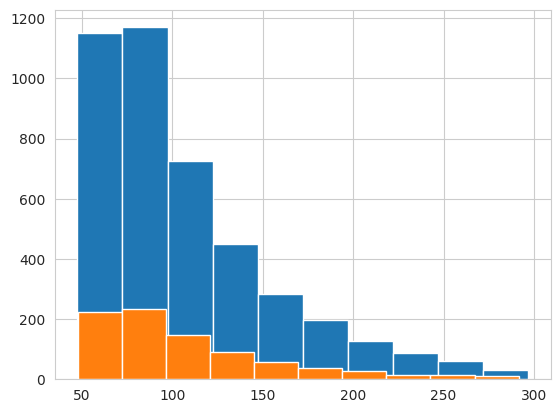

In [ ]:
def percentile_bins(series, n_bins):
    """Zwraca granice n_bins równych percentyli"""
    bins = np.percentile(series, np.linspace(0, 100, n_bins + 1))
    categories = pd.cut(series, bins=bins, labels=False, include_lowest=True)
    return bins, categories

# Użycie:
bins, categories = percentile_bins(y_train, 10)

df = pd.DataFrame({'values': y_train, 'category': categories})

sampled = df.groupby('category', group_keys=False).apply(
        lambda x: x.sample(frac=0.2, random_state=42)
    )
plt.hist(y_train)
plt.hist(sampled['values'], bins=10)
plt.show()

In [ ]:
# Dla porównania - dane bez stratyfikacji
from sklearn.model_selection import train_test_split
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
                                                    data_encoded,
                                                    data_encoded.price,
                                                    test_size=0.20,
                                                    random_state=42)

(<Axes: >, <Axes: >, <Axes: >)

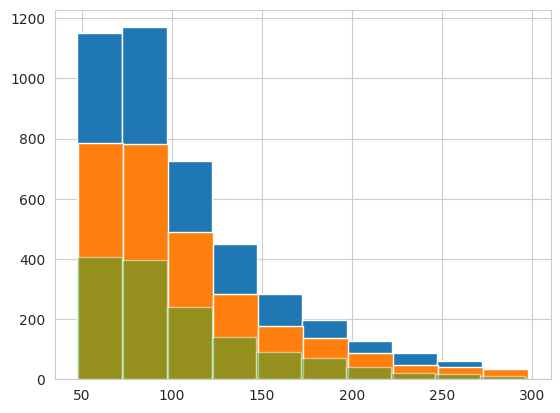

In [ ]:
# porównanie danych bez stratyfikacji i ze stratyfikacją
y_train.hist(), y_test.hist(), y_test_no.hist(alpha=0.5)

# MODELLING - regresja
OLS - ordinary least squares - zwykła metoda najmniejszych kwadratów

In [ ]:
X['log_price'] = X.price.apply(np.log)
X.head(3)

id                                       listing_url       scrape_id last_scraped       source                                               name                                        description                                        picture_url neighbourhood_cleansed   latitude  longitude       property_type        room_type  accommodates  bathrooms bathrooms_text  bedrooms  beds                                          amenities     price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  availability_eoy  estimated_occupancy_l365d  estimated_revenue_l365d  instant_bookable  lat_dist_mean  lon_dist_mean  lat_dist_center  lon_dist_center  dist_from_center  n_amenities                                   amenities_parsed  is_fire_extinguisher  is_shower_gel  is_hot_water_kettle  is_dishwasher  is_dishes_and_silverware  is_body_soap  is_extra_pillows_and_blankets  is_cooking_basics  is_elevator  is_microwave  is_conditioner  is_freezer  is_cleaning_products  is_self_check_in  is_coffee  is_free_washer___in_unit  is_carbon_monoxide_alarm  is_essentials  is_refrigerator  is_long_term_stays_allowed  is_luggage_dropoff_allowed  is_first_aid_kit  is_wine_glasses  is_coffee_maker  is_clothing_storage_closet  is_iron  is_dining_table  is_books_and_reading_material  is_bed_linens  is_hot_water  is_central_heating  is_smoke_alarm  is_paid_parking_off_premises  is_bathtub  is_hair_dryer  is_private_entrance  is_toaster  is_single_level_home  is_hangers  is_room_darkening_shades  is_wifi  is_drying_rack_for_clothing  is_shampoo  is_kitchen  is_ethernet_connection  is_heating  is_stove  is_washer  is_dryer  is_dedicated_workspace  is_host_greets_you  is_oven  is_pack_n_play_travel_crib  is_lockbox  is_pets_allowed  is_tv  is_clothing_storage  is_portable_fans  is_paid_street_parking_off_premises  is_high_chair  is_exterior_security_cameras_on_property  is_laundromat_nearby  is_outdoor_furniture  is_crib  is_mini_fridge  is_air_conditioning  is_paid_parking_on_premises  is_baking_sheet  is_private_patio_or_balcony  is_coffee_maker_nespresso  log_price  log2_price  log3_price  log4_price  log5_price  sqrt_price  property_type_map_Entire_guest_suite  property_type_map_Entire_home  property_type_map_Entire_loft  property_type_map_Entire_rental_unit  property_type_map_Entire_serviced_apartment  property_type_map_other  neighbourhood_cleansed_map_Praha_1  neighbourhood_cleansed_map_Praha_10  neighbourhood_cleansed_map_Praha_11  neighbourhood_cleansed_map_Praha_12  neighbourhood_cleansed_map_Praha_13  neighbourhood_cleansed_map_Praha_14  neighbourhood_cleansed_map_Praha_15  neighbourhood_cleansed_map_Praha_18  neighbourhood_cleansed_map_Praha_2  neighbourhood_cleansed_map_Praha_3  neighbourhood_cleansed_map_Praha_4  neighbourhood_cleansed_map_Praha_5  neighbourhood_cleansed_map_Praha_6  neighbourhood_cleansed_map_Praha_7  neighbourhood_cleansed_map_Praha_8  neighbourhood_cleansed_map_Praha_9  neighbourhood_cleansed_map_Velká_Chuchle  neighbourhood_cleansed_map_Zbraslav  neighbourhood_cleansed_map_Zličín  neighbourhood_cleansed_map_other price_category
3475             49665402             https://www.airbnb.com/rooms/49665402  20250923203415   2025-09-23  city scrape                                 Apartmán IRON CUBE  During this unique and peaceful stay, you will...  https://a0.muscache.com/pictures/miso/Hosting-...               Praha 22  50.016851  14.581410        Entire condo  Entire home/apt             2        1.0         1 bath       0.0   2.0  ["Hot water kettle", "Dishes and silverware", ...  115.9020               1             365                     2.0                     2.0                   150.0                   150.0                     2.0                   150.0                t               2

To use:
 + neighbourhood_cleansed_map
 + property_type_map

+ C(neighbourhood_cleansed_map,  Treatment(reference="other"))
+ C(property_type_map,  Treatment(reference="other"))

## 1 Model fit - simple

one-hot code encoding - C oznacza ze to kategoryczna

*zmienne   P>|t| > 0.2 na pewno do wywalenia*

Znaczenie zmiennych:
* **accommodates** - liczba osób którą pomieści

Brakuje zmiennej '**guests included**' ale chyba accommodates to jest to samo



In [ ]:
# Our first linear model
model = smf.ols(
    '''price ~ accommodates
                   + bathrooms
                   + bedrooms
                   + beds
                   + minimum_nights
                   + maximum_nights
                   + availability_30
                   + availability_60
                   + availability_90
                   + availability_365
                   + is_wifi
                   + is_tv
                   + is_essentials
                   + n_amenities
                   + lat_dist_mean
                   + lon_dist_mean
                   + dist_from_center
                   + neighbourhood_cleansed_map
                   + property_type_map
    ''',
    data=data).fit()

# Inspect the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     132.3
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:25:31   Log-Likelihood:                -36035.
No. Observations:                7151   AIC:                         7.216e+04
Df Residuals:                    7107   BIC:                         7.246e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### RMSE

In [ ]:
'''RMSE wciąż lewa strona jest bardziej skośna robimy logarytm z ceny
'''
np.sqrt(model.mse_resid)

np.float64(37.4599301248953)

In [ ]:
# Calculate residuals
residuals = data['price'] - (model.predict(model.model.data.frame))

# Calculate RMSE
rmse = np.sqrt(np.mean(residuals**2))
rmse

np.float64(37.34450709662932)

In [ ]:
import plotly.express as px
px.histogram(model.resid)

### Test Shapiro-Wilka

In [ ]:
from scipy.stats import shapiro
from scipy.stats import jarque_bera

stat, p_value = shapiro(residuals)

print(f"Statystyka testu Shapiro-Wilka: {stat:.3f}")
print(f"Wartość p: {p_value:.3f}")

# Interpretacja wyniku
if p_value > 0.05:
    print("Brak dowodów na odrzucenie hipotezy zerowej – reszty pochodzą z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę zerową – reszty nie pochodzą z rozkładu normalnego.")
print()

stat, p_value = jarque_bera(model.resid)

print(f"Statystyka testu Jarque-Bera: {stat:.3f}")
print(f"Wartość p: {p_value:.3f}")

# Interpretacja
if p_value < 0.05:
    print("Odrzucamy hipotezę zerową – dane nie pochodzą z rozkładu normalnego.")
else:
    print("Brak dowodów na odrzucenie hipotezy zerowej – dane mogą pochodzić z rozkładu normalnego.")


Statystyka testu Shapiro-Wilka: 0.925
Wartość p: 0.000
Odrzucamy hipotezę zerową – reszty nie pochodzą z rozkładu normalnego.

Statystyka testu Jarque-Bera: 3933.067
Wartość p: 0.000
Odrzucamy hipotezę zerową – dane nie pochodzą z rozkładu normalnego.


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7151.



# MODELE xgBOOST

scikitlearnowy troche

gradient boosting

różne opcje adaptacji, różne optymalizacje

xgBOOST - wprowadza dużo zmiennych, pokonuje wszystkie inne drzewa losowe, zaimplementowany pod spodem przez matematyczne wyprowadzenia, można go trenować przy wykorzystaniu karty graficznej. Szybciej działa.

Duże sieci neuronowe - na kartach graficznych - do macierzy.

n_estimators - liczba estymatorów, czyli liczba drzew które są wykorzystywane tutaj

wyszukiwanie hiperparametrów - grid search, random search, bayesian opt,

---> w finale - brute force, trzeba zobaczyć które hiperparametry dadzą najlepsze wyniki  

In [ ]:
# ?xgboost.XGBRegressor

# https://xgboost.readthedocs.io/en/stable/

## xgBoost v1

In [ ]:
# XGBoost simple

variables = ['bathrooms', 'bedrooms', 'beds', 'accommodates', 'minimum_nights']

# data_subset = X_train.loc[:, variables + ['price']]
# data_subset = data_subset.iloc[:5000,:] # oryginalnie

#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
X = X_train.loc[:, variables]
y = np.array(X_train.price)

model = xgboost.XGBRegressor(n_estimators=200, verbosity=1)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# wymiar danych do analizy
X.shape, X_train.shape, X_test.shape

((4290, 5), (4290, 148), (2861, 148))

### RMSE - zbiór treningowy

In [ ]:
# What does it even mean? Todo: check different error functions and how they can be explained
# Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

predicted = model.predict(X)
# list(zip(data_subset.price[0:10], predicted[0:10]))

# rmse dla modelu na zbiorze treningowym
np.sqrt(mean_squared_error(y, predicted))

np.float64(33.92671301518888)

In [ ]:
px.histogram(X_train.price - predicted )

### RMSE - zbiór walidacyjny

In [ ]:
# What does it even mean? Todo: check different error functions and how they can be explained
# Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)
X_val = X_test.loc[:, variables]
y_val = np.array(X_test.price)

predicted_test = model.predict(X_val)
residuals = (X_test.price - predicted_test)

# Calculate RMSE dla zbioru testowego
rmse = np.sqrt(mean_squared_error(y_val, predicted_test))
print(f"RMSE: {rmse:.2f}")

# Inne metryki - MAE = mean absolute error
mae = np.mean(np.abs(residuals))
print(f"MAE: {mae:.2f}")

RMSE: 42.90
MAE: 31.11


In [ ]:
px.histogram(residuals)

## xgBoost v2 - all

In [ ]:
# XGBoost

variables = [
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'minimum_nights',
    'maximum_nights',
    # 'minimum_minimum_nights', ### <--- te parametry wykluczam z analizy, opisują wyniki mieszkania niezależnie od jego obiektywnych cech
    # 'maximum_minimum_nights',
    # 'minimum_maximum_nights',
    # 'maximum_maximum_nights',
    # 'minimum_nights_avg_ntm',
    # 'maximum_nights_avg_ntm',
    # 'availability_30',
    # 'availability_60',
    # 'availability_90',
    # 'availability_365',
    # 'availability_eoy',
    # 'estimated_occupancy_l365d',
    # 'estimated_revenue_l365d',
    'instant_bookable',
    'lat_dist_mean',
    'lon_dist_mean',
    'dist_from_center',
    'n_amenities',
    'is_fire_extinguisher',
    'is_shower_gel',
    'is_hot_water_kettle',
    'is_dishwasher',
    'is_dishes_and_silverware',
    'is_body_soap',
    'is_extra_pillows_and_blankets',
    'is_cooking_basics',
    'is_elevator',
    'is_microwave',
    'is_conditioner',
    'is_freezer',
    'is_cleaning_products',
    'is_self_check_in',
    'is_coffee',
    'is_free_washer___in_unit',
    'is_essentials',
    'is_refrigerator',
    'is_long_term_stays_allowed',
    'is_luggage_dropoff_allowed',
    'is_wine_glasses',
    'is_coffee_maker',
    'is_clothing_storage_closet',
    'is_iron',
    'is_dining_table',
    'is_books_and_reading_material',
    'is_bed_linens',
    'is_hot_water',
    'is_central_heating',
    'is_smoke_alarm',
    'is_bathtub',
    'is_hair_dryer',
    'is_private_entrance',
    'is_toaster',
    'is_single_level_home',
    'is_hangers',
    'is_room_darkening_shades',
    'is_wifi',
    'is_drying_rack_for_clothing',
    'is_shampoo',
    'is_kitchen',
    'is_ethernet_connection',
    'is_heating',
    'is_stove',
    'is_washer',
    'is_dryer',
    'is_dedicated_workspace',
    'is_host_greets_you',
    'is_oven',
    'is_pack_n_play_travel_crib',
    'is_lockbox',
    'is_pets_allowed',
    'is_tv',
    'is_clothing_storage',
    'is_portable_fans',
    'is_high_chair',
    'is_exterior_security_cameras_on_property',
    'is_laundromat_nearby',
    'is_outdoor_furniture',
    'is_crib',
    'is_air_conditioning',
    'is_baking_sheet',
    'is_private_patio_or_balcony',
    'is_coffee_maker_nespresso',
    'property_type_map_Entire_guest_suite',
    'property_type_map_Entire_home',
    'property_type_map_Entire_loft',
    'property_type_map_Entire_rental_unit',
    'property_type_map_Entire_serviced_apartment',
    'property_type_map_other',
    'neighbourhood_cleansed_map_Praha_1',
    'neighbourhood_cleansed_map_Praha_10',
    'neighbourhood_cleansed_map_Praha_11',
    'neighbourhood_cleansed_map_Praha_12',
    'neighbourhood_cleansed_map_Praha_13',
    'neighbourhood_cleansed_map_Praha_14',
    'neighbourhood_cleansed_map_Praha_15',
    'neighbourhood_cleansed_map_Praha_18',
    'neighbourhood_cleansed_map_Praha_2',
    'neighbourhood_cleansed_map_Praha_3',
    'neighbourhood_cleansed_map_Praha_4',
    'neighbourhood_cleansed_map_Praha_5',
    'neighbourhood_cleansed_map_Praha_6',
    'neighbourhood_cleansed_map_Praha_7',
    'neighbourhood_cleansed_map_Praha_8',
    'neighbourhood_cleansed_map_Praha_9',
    'neighbourhood_cleansed_map_Velká_Chuchle',
    'neighbourhood_cleansed_map_Zbraslav',
    'neighbourhood_cleansed_map_Zličín',
    'neighbourhood_cleansed_map_other'
]

print(variables)

# data_subset = data_encoded.loc[:, variables + ['price']]

#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
X = X_train.loc[:, variables]
y = np.array(X_train.price)

model = xgboost.XGBRegressor(n_estimators=200, verbosity=1)
model.fit(X, y)

['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'instant_bookable', 'lat_dist_mean', 'lon_dist_mean', 'dist_from_center', 'n_amenities', 'is_fire_extinguisher', 'is_shower_gel', 'is_hot_water_kettle', 'is_dishwasher', 'is_dishes_and_silverware', 'is_body_soap', 'is_extra_pillows_and_blankets', 'is_cooking_basics', 'is_elevator', 'is_microwave', 'is_conditioner', 'is_freezer', 'is_cleaning_products', 'is_self_check_in', 'is_coffee', 'is_free_washer___in_unit', 'is_essentials', 'is_refrigerator', 'is_long_term_stays_allowed', 'is_luggage_dropoff_allowed', 'is_wine_glasses', 'is_coffee_maker', 'is_clothing_storage_closet', 'is_iron', 'is_dining_table', 'is_books_and_reading_material', 'is_bed_linens', 'is_hot_water', 'is_central_heating', 'is_smoke_alarm', 'is_bathtub', 'is_hair_dryer', 'is_private_entrance', 'is_toaster', 'is_single_level_home', 'is_hangers', 'is_room_darkening_shades', 'is_wifi', 'is_drying_rack_for_clothing', 'is_shampoo', 'is_kitc

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

### RMSE - zbiór treningowy

In [ ]:
# What does it even mean? Todo: check different error functions and how they can be explained
# Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

predicted = model.predict(X)
# list(zip(data_subset.price[0:10], predicted[0:10]))

# rmse dla modelu na zbiorze treningowym
np.sqrt(mean_squared_error(y, predicted))

np.float64(4.236718572150956)

In [ ]:
px.histogram(X_train.price - predicted)

### RMSE - zbiór walidacyjny

In [ ]:
# What does it even mean? Todo: check different error functions and how they can be explained
# Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)
X_val = X_test.loc[:, variables]
y_val = np.array(X_test.price)

predicted_test = model.predict(X_val)
residuals = (X_test.price - predicted_test)

# Calculate RMSE dla zbioru testowego
rmse = np.sqrt(mean_squared_error(y_val, predicted_test))
print(f"RMSE: {rmse:.2f}")

# Inne metryki - MAE = mean absolute error
mae = np.mean(np.abs(residuals))
print(f"MAE: {mae:.2f}")

RMSE: 33.99
MAE: 23.31


In [ ]:
px.histogram(residuals)

## xgBoost v3 - final
Takie same zmienne wykorzystane jak w finalnym modelu liniowym.

In [ ]:
# XGBoost

variables = [
    'bedrooms',
    'accommodates',
    'bathrooms',
    'dist_from_center',
    'lon_dist_mean',
    'lat_dist_mean',
    'minimum_nights',
    'property_type_map_Entire_serviced_apartment',
    'property_type_map_Entire_rental_unit',
    'property_type_map_other',
    'instant_bookable',
    'n_amenities',
    'is_air_conditioning',
    'is_dishwasher',
    'is_tv',
    'is_dishes_and_silverware',
    'is_essentials',
    'is_self_check_in',
    'is_microwave',
    'is_coffee',
    'is_iron',
    'is_refrigerator',
    'is_lockbox',
    'is_bed_linens',
    'is_bathtub',
    'is_wifi',
    'is_private_patio_or_balcony',
    'is_hot_water',
    'is_books_and_reading_material',
    'is_kitchen'
]

variables_used = variables

print(variables)

#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
X = X_train.loc[:, variables]
y = np.array(X_train.price)

model = xgboost.XGBRegressor(n_estimators=200, verbosity=1)
model.fit(X, y)

# ### OPCJA DLA ZBIORU TESTOWEGO ORAZ WALIDACYJNEGO - NISKA POPRAWA, BEZ SENSU
# X_val = X_test.loc[:, variables]
# y_val = np.array(X_test.price)
#
# model = xgboost.XGBRegressor(
#     n_estimators=1000,  # Maksymalnie 1000 drzew
#     early_stopping_rounds=50  # Zatrzymaj jeśli przez 50 rund brak poprawy
# )

# model.fit(
#     X, y,
#     eval_set=[(X_val, y_val)],  # KLUCZOWE!
#     verbose=False
# )

['bedrooms', 'accommodates', 'bathrooms', 'dist_from_center', 'lon_dist_mean', 'lat_dist_mean', 'minimum_nights', 'property_type_map_Entire_serviced_apartment', 'property_type_map_Entire_rental_unit', 'property_type_map_other', 'instant_bookable', 'n_amenities', 'is_air_conditioning', 'is_dishwasher', 'is_tv', 'is_dishes_and_silverware', 'is_essentials', 'is_self_check_in', 'is_microwave', 'is_coffee', 'is_iron', 'is_refrigerator', 'is_lockbox', 'is_bed_linens', 'is_bathtub', 'is_wifi', 'is_private_patio_or_balcony', 'is_hot_water', 'is_books_and_reading_material', 'is_kitchen']


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

### RMSE - zbiór treningowy

In [ ]:
# What does it even mean? Todo: check different error functions and how they can be explained
# Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

predicted = model.predict(X)
# list(zip(data_subset.price[0:10], predicted[0:10]))

# rmse dla modelu na zbiorze treningowym
np.sqrt(mean_squared_error(y, predicted))

np.float64(5.938975435719861)

In [ ]:
px.histogram( X_train.price - predicted )

### RMSE - zbiór walidacyjny

In [ ]:
# What does it even mean? Todo: check different error functions and how they can be explained
# Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)
X_val = X_test.loc[:, variables]
y_val = np.array(X_test.price)

predicted_test = model.predict(X_val)
residuals = (X_test.price - predicted_test)

# Calculate RMSE dla zbioru testowego
rmse = np.sqrt(mean_squared_error(y_val, predicted_test))
print(f"RMSE: {rmse:.2f}")

# Inne metryki - MAE = mean absolute error
mae = np.mean(np.abs(residuals))
print(f"MAE: {mae:.2f}")

RMSE: 35.51
MAE: 24.60


### Dla OLS jest RMSE = 39.2, MAE = 26.6 (Praga)

In [ ]:
px.histogram(residuals)

In [ ]:
# Eksport parametrów z xgBoosta
# 1. Feature importances
feature_importance = pd.DataFrame({
    'feature': variables,  # Używamy variables zamiast X.columns
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.to_excel('xgboost_feature_importance.xlsx', index=False)
print("\n=== Feature Importance ===")
print(feature_importance)

# 2. Parametry modelu (hiperparametry)
params = model.get_params()
params_df = pd.DataFrame(params.items(), columns=['parameter', 'value'])
params_df.to_excel('xgboost_params.xlsx', index=False)

# 3. Kompletny raport (oba w jednym pliku)
with pd.ExcelWriter('xgboost_full_report.xlsx') as writer:
    feature_importance.to_excel(writer, sheet_name='Feature Importance', index=False)
    params_df.to_excel(writer, sheet_name='Model Parameters', index=False)

print("\nParametry wyeksportowane do plików Excel!")

# 4. Opcjonalnie: zapisz cały model
model.save_model('xgboost_model.json')
print("Model zapisany do xgboost_model.json")


=== Feature Importance ===
                                        feature  importance
0                                      bedrooms    0.116633
2                                     bathrooms    0.091082
7   property_type_map_Entire_serviced_apartment    0.074012
9                       property_type_map_other    0.066283
12                          is_air_conditioning    0.061045
27                                 is_hot_water    0.055434
15                     is_dishes_and_silverware    0.054901
13                                is_dishwasher    0.049381
10                             instant_bookable    0.030900
6                                minimum_nights    0.029994
23                                is_bed_linens    0.028016
3                              dist_from_center    0.027169
28                is_books_and_reading_material    0.026100
22                                   is_lockbox    0.024804
1                                  accommodates    0.024165
16          

# !!! Wynik
Bardzo dobry na danych treningowych, średni na danych validacyjnych (ale nieco lepszy od OLS).

Lepsze RMSE, ale duża skośność. Jednak, tutaj już nieistotne czy ten rozkład jest normalny czy nie.

DRZEWA DECYZYJNE TO MODELE NIELINIOWE - WIĘC NIE PATRZYMY NA ROZKŁAD NORMALNY

# OPŁACALNOŚĆ MIESZKAŃ - Estymacja ceny m2, powierzchni, opłacalności

In [ ]:
# data_encoded.T.head(100)

## Normalizacja dist_from_center

In [ ]:
data_encoded['dist_from_center'].describe()

# Min-Max normalization of dist_from_center
min_val = data_encoded['dist_from_center'].min()
max_val = data_encoded['dist_from_center'].max()

data_encoded['dist_from_center'] = (data_encoded['dist_from_center'] - min_val) / (max_val - min_val)

data_encoded['dist_from_center'].describe()

count    7151.000000
mean        0.100167
std         0.102926
min         0.000000
25%         0.040031
50%         0.068286
75%         0.123355
max         1.000000
Name: dist_from_center, dtype: float64

## Założenia, obliczenia: powierzchni, ceny mieszkania, i opłacalności

In [ ]:
X_all = data_encoded.loc[:, variables]
predictions = model.predict(X_all)

data_encoded['price_predictions'] = predictions
data_encoded['price_residuals'] = residuals
data_encoded['price_residuals_abs_err'] = data_encoded['price_residuals'].abs()

# Praga - założenia zmiennej - 5000 eur/m2 na obrzeżach, 8000 eur/m2 w centrum
# założenia - średnie mieszkanie ma 50 m2
data_encoded['m2_price'] = 5000 + data_encoded['dist_from_center']*3000

# Praga - typowa kawalerka ma 30 m2 = 1 łazienka i 1 sypialnia
data_encoded['area_m2'] = 20 + data_encoded['bedrooms']*10 + data_encoded['bathrooms']*5 ### można jednak założyć, że w Pradze mieszkania są nieco mniejsze
data_encoded['apt_purchase_price'] = data_encoded['area_m2']*data_encoded['m2_price']
# Czas do zwrotu inwestycji - w dniach
data_encoded['payback_time'] = data_encoded['apt_purchase_price']/data_encoded['price_predictions']

data_encoded.head(10).T

2                                                  4                                                  5                                                  6                                                  7                                                  12                                                 13                                                 14                                                 15                                                 17
id                                                                                       26755                                              42514                                              52148                                              55856                                              75298                                              83067                                              83855                                              83856                                              85790                                             106207
listing_url                                                 https://www.airbnb.com/rooms/26755                 https://www.airbnb.com/rooms/42514                 https://www.airbnb.com/rooms/52148                 https://www.airbnb.com/rooms/55856                 https://www.airbnb.com/rooms/75298                 https://www.airbnb.com/rooms/83067                 https://www.airbnb.com/rooms/83855                 https://www.airbnb.com/rooms/83856                 https://www.airbnb.com/rooms/85790                https://www.airbnb.com/rooms/106207
scrape_id                                                                       20250923203415                                     20250923203415                                     20250923203415                                     20250923203415                                     20250923203415                                     20250923203415                                     20250923203415                                     20250923203415                                     20250923203415                                     20250923203415
last_scraped                                                                        2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24                                         2025-09-24
source                                                                             city scrape                                        city scrape                                        city scrape                                        city scrape                                        city scrape                                        city scrape                                        city scrape                                        city scrape                                        city scrape                                        city scrape
name                                                         Central Prague Old Town Top Floor  "NEWLY FURNISHED" 1BR near Pachtuv Palace,Old ...                     Colorful 2BDR Family Apartment         Renovated Apartment behind National Museum                          Prague  Studio  Old  Town                Old Town Apartment Charles Bridge 3                Old Town Apartment Charles Bridge 4                Charles Bridge Old Town Apartment 5                Grande apartment 43 with River View            Welcome To The Jungle Studio By Ruterra
description                                  Big and beautiful new attic apartment in the v...  *NEWLY* Furnished 1-bedroom apartment on the f...  -The apartment has a self-check-in through a l...  Cozy and well-eq

## Podsumowanie opłacalności

In [ ]:
# Agregacja wyników - Praga
summary = data_encoded[['price','price_predictions','price_residuals','price_residuals_abs_err','area_m2','apt_purchase_price','payback_time']].describe()
summary.style.format({
    'price': '{:.1f}',
    'price_predictions': '{:.1f}',
    'price_residuals': '{:.1f}',
    'price_residuals_abs_err': '{:.1f}',
    'area_m2': '{:.1f}',
    'apt_purchase_price': '{:,.0f}',
    'payback_time': '{:,.0f}'
})

## Analiza outlierów

In [ ]:
# Top 10 z wybranymi kolumnami
cols = ['price', 'price_predictions', 'price_residuals', 'bedrooms', 'bathrooms', 'accommodates','area_m2','dist_from_center','apt_purchase_price','payback_time']
data_encoded.nsmallest(10, 'price_residuals')[cols]

price  price_predictions  price_residuals  bedrooms  bathrooms  accommodates  area_m2  dist_from_center  apt_purchase_price  payback_time
644     74.2266         231.267151      -171.760491       3.0        2.5             8     62.5          0.455925       397985.944491   1720.892669
3058    92.4750         240.272583      -162.517584       3.0        2.5             8     62.5          0.456811       398151.979915   1657.084528
9130    76.0350         119.078423      -125.434879       1.0        1.0             4     35.0          0.029597       178107.649315   1495.717238
3941    54.4575         176.808701      -122.351201       3.0        1.0             7     55.0          0.608596       375418.366070   2123.302557
1626    73.2402         194.631332      -120.709995       3.0        1.0             7     55.0          0.471608       352815.368639   1812.736748
1048    79.8984          97.424400      -116.183463       2.0        1.0             5     45.0          0.016710       227255.906361   2332.638493
10662   78.0900         233.458923      -116.079861       4.0        2.0            12     70.0          0.061270       362866.703290   1554.306420
10468   85.1592         145.251953      -114.967936       1.0        1.0             4     35.0          0.240589       200261.871316   1378.720678
18      97.2015         160.142105      -110.779945       2.0        1.0             3     45.0          0.021807       227943.894169   1423.385149
4365   105.5448         221.779556      -105.376785       2.0        2.0             6     50.0          0.060174       259026.143115   1167.944185

In [ ]:
# Top 10 z wybranymi kolumnami
cols = ['price', 'price_predictions', 'price_residuals', 'bedrooms', 'bathrooms', 'accommodates','area_m2','dist_from_center','apt_purchase_price','payback_time']
data_encoded.nlargest(10, 'price_residuals')[cols]

price  price_predictions  price_residuals  bedrooms  bathrooms  accommodates  area_m2  dist_from_center  apt_purchase_price  payback_time
693    260.6562          71.830147       194.164974       1.0        1.5             4     37.5          0.090565       197688.569481   2752.167138
4047   276.5619         121.687218       187.236689       1.0        1.0             2     35.0          0.064863       181810.609981   1494.081411
10585  279.5622          97.699730       181.388067       1.0        1.0             5     35.0          0.034450       178617.265373   1828.226808
512    267.8076          97.020805       176.947798       2.0        1.0             5     45.0          0.082773       236174.385591   2434.265359
2565   234.2700          50.472618       176.802059       0.0        1.0             4     25.0          0.051142       128835.667307   2552.585385
2681   273.7260         111.184196       173.832842       0.0        1.0             4     25.0          0.136490       135236.743319   1216.330626
9546   278.6580         120.215988       168.781901       2.0        1.0             4     45.0          0.111520       240055.218236   1996.865990
3168   239.1609          70.528427       163.273846       1.0        1.5             3     37.5          0.205630       210633.384843   2986.503364
5448   244.1340          70.011826       159.932363       1.0        1.0             4     35.0          0.089410       184388.034036   2633.669849
8271   296.1666          86.515762       159.049870       2.0        1.0             5     45.0          0.058604       232911.515298   2692.128105

In [ ]:
# Top 10 z wybranymi kolumnami
cols = ['price', 'price_predictions', 'price_residuals', 'bedrooms', 'bathrooms', 'accommodates','area_m2','dist_from_center','apt_purchase_price','payback_time']
data_encoded.nsmallest(10, 'price_predictions')[cols]

price  price_predictions  price_residuals  bedrooms  bathrooms  accommodates  area_m2  dist_from_center  apt_purchase_price  payback_time
9555   57.5400          23.583956              NaN       1.0        1.0             1     35.0          0.049602       180208.227931   7641.136615
6480   49.7721          25.530027        -9.636401       1.0        1.0             2     35.0          0.096150       185095.715140   7250.118158
8902   58.2387          29.536001              NaN       1.0        1.0             2     35.0          0.092341       184695.838912   6253.244562
9458   47.9637          29.638657        -0.362663       1.0        1.0             2     35.0          0.106537       186186.349102   6281.875441
969    53.4300          31.999319              NaN       1.0        1.5             2     37.5          0.096546       198361.477376   6198.928074
4508   59.3895          32.165016         8.855629       0.0        1.0             2     25.0          0.055350       129151.233630   4015.270284
4400   62.2254          32.760342        -0.928069       0.0        1.0             2     25.0          0.050464       128784.815671   3931.119433
3044   67.5273          33.032936        12.348909       1.0        1.0             2     35.0          0.113041       186869.317142   5657.060474
5125   58.1565          33.098450              NaN       1.0        1.0             2     35.0          0.077521       183139.654638   5533.179235
10176  73.8978          33.435673              NaN       1.0        1.0             4     35.0          0.045228       179748.915169   5375.962268

# Analiza SHAP-a

nie ma ograniczeń ile wartości SHAP-a mogą wynosić.

Przy klasyfikacji - powinny sumować się do 1.

Guest_included - ile może być gości.

Bathrooms - może być korelacja z bedrooms.

### Google Drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load & Save

In [ ]:
import pickle
import os

# x=X_val.iloc[:100] ### wycinek danych
# y=y_val[:100]
x=X_val
y=y_val
force_restart = 0

# Prefix dla nazw plików i nazwy zmiennych
pre = 'predictions_Prague_XGB'
expl = 'explainer'
shap_vals = 'shap_values'

# Ścieżka do Google Drive
SAVE_PATH = '/content/drive/MyDrive/shap_models/'

# Sprawdź czy pliki istnieją
files_exist = all([
    os.path.exists(f'{pre}_X_data.pkl'),
    os.path.exists(f'{pre}_{shap_vals}.pkl'),
    os.path.exists(f'{pre}_{expl}.pkl')
])

# Pełne ścieżki do plików
x_data_path = f'{SAVE_PATH}{pre}_X_data.pkl'
shap_vals_path = f'{SAVE_PATH}{pre}_{shap_vals}.pkl'
explainer_path = f'{SAVE_PATH}{pre}_{expl}.pkl'

# Sprawdź czy pliki istnieją
files_exist = all([
    os.path.exists(x_data_path),
    os.path.exists(shap_vals_path),
    os.path.exists(explainer_path)
])

# Logika: wczytaj tylko jeśli pliki istnieją & force_restart == 0
if files_exist and force_restart == 0:
    print("📂 Wczytywanie zapisanych danych SHAP z Google Drive...")

    with open(x_data_path, 'rb') as f:
        X = pickle.load(f)

    with open(shap_vals_path, 'rb') as f:
        shap_values = pickle.load(f)

    with open(explainer_path, 'rb') as f:
        explainer = pickle.load(f)

    print("✓ Dane SHAP wczytane pomyślnie z Google Drive!")

# Logika: licz ponownie jeśli force_restart == 1 lub brak plików
else:
    if force_restart == 1:
        print("🔄 force_restart=1 - Pomijam wczytywanie, tworzę model od nowa...")
    else:
        print("⚙️  Pliki SHAP nie znalezione. Tworzenie nowego modelu SHAP...")

    print("⏳ To może potrwać kilka minut...")

    ###############################
    # Wykonaj modelowanie SHAP ####
    explainer = shap.Explainer(model.predict, x)
    shap_values = explainer(x)
    ###############################

    print("💾 Zapisywanie wyników do Google Drive...")

    # Zapisz wyniki do Google Drive
    with open(x_data_path, 'wb') as f:
        pickle.dump(x, f)

    with open(shap_vals_path, 'wb') as f:
        pickle.dump(shap_values, f)

    with open(explainer_path, 'wb') as f:
        pickle.dump(explainer, f)

    print(f"✓ Model SHAP utworzony i zapisany w {SAVE_PATH}!")

# Weryfikacja
print(f"\n📊 Kształt X: {x.shape}")
print(f"📊 Liczba obserwacji: {len(shap_values)}")

# Wyświetl rozmiary plików w Google Drive
print(f"\n📁 Pliki w {SAVE_PATH}:")
!ls -lh "{SAVE_PATH}"{pre}_*.pkl 2>/dev/null || echo "Pliki zapisane"

📂 Wczytywanie zapisanych danych SHAP z Google Drive...
✓ Dane SHAP wczytane pomyślnie z Google Drive!

📊 Kształt X: (2861, 30)
📊 Liczba obserwacji: 2861

📁 Pliki w /content/drive/MyDrive/shap_models/:
-rw------- 1 root root 835K Jan 14 20:22 /content/drive/MyDrive/shap_models/predictions_Prague_XGB_explainer.pkl
-rw------- 1 root root 1.4M Jan 14 20:22 /content/drive/MyDrive/shap_models/predictions_Prague_XGB_shap_values.pkl
-rw------- 1 root root 695K Jan 14 20:22 /content/drive/MyDrive/shap_models/predictions_Prague_XGB_X_data.pkl


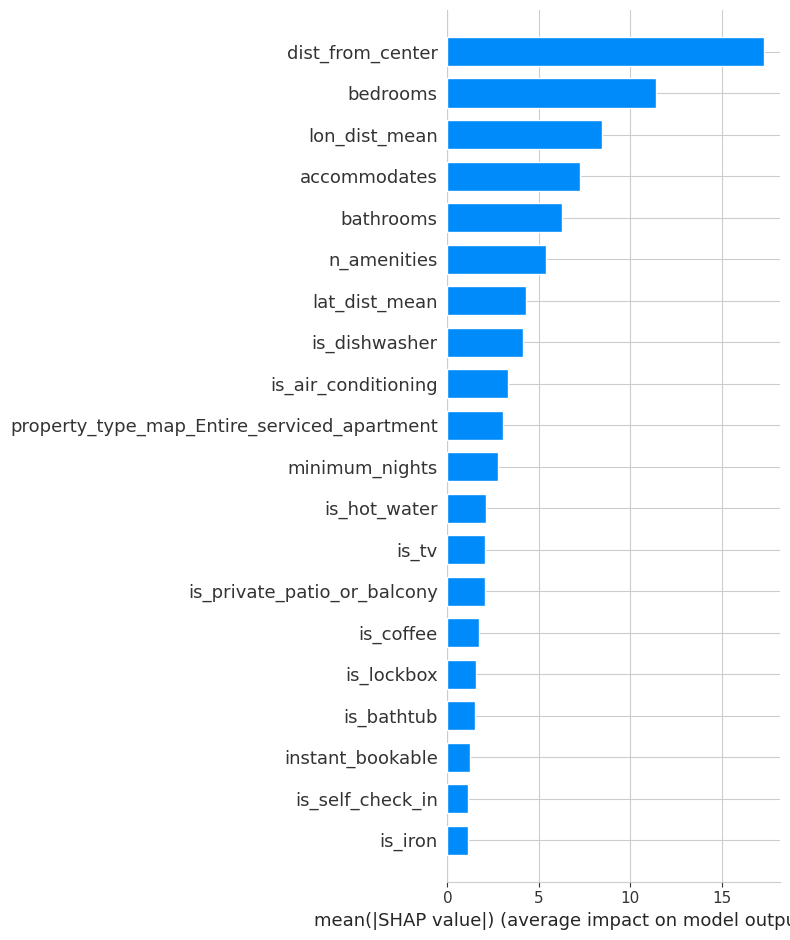

In [ ]:
shap.summary_plot(shap_values, x, plot_type="bar")

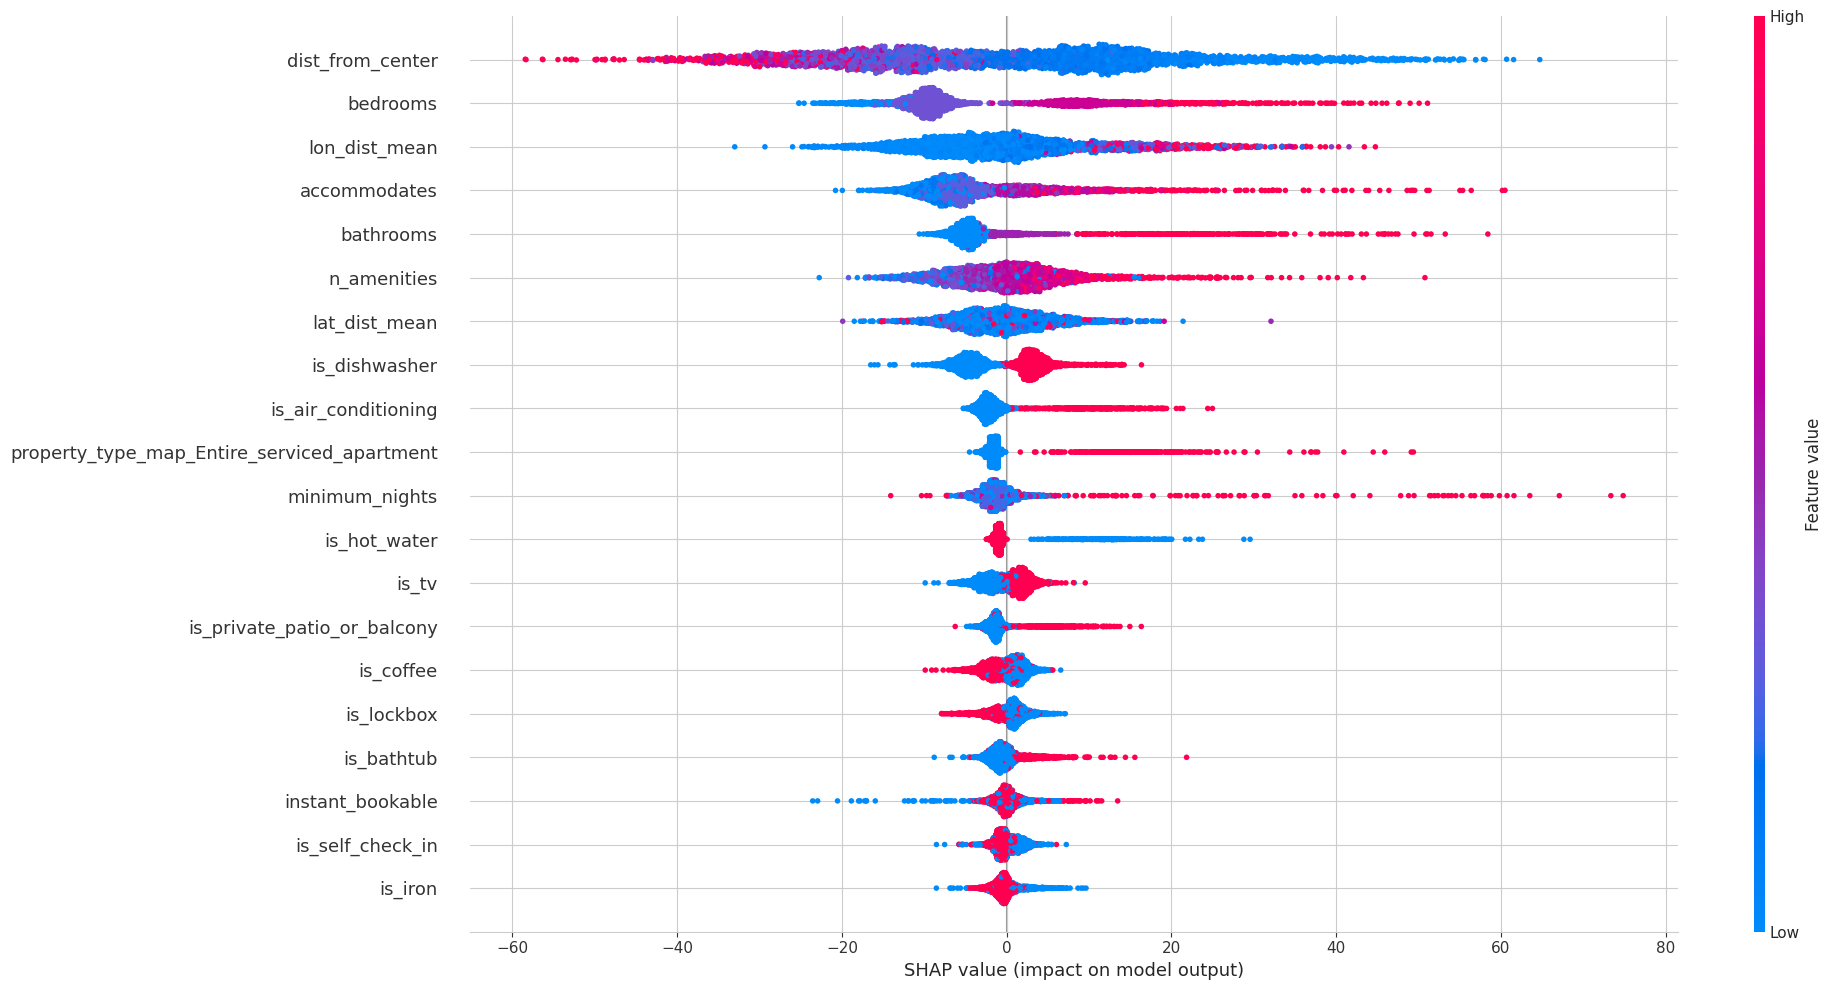

In [ ]:
#From official documentation:
'''The summary plot combines feature importance with feature effects.
Each point on the summary plot is a Shapley value for a feature and an instance.
The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.
The color represents the value of the feature from low to high.
Overlapping points are jittered in y-axis direction, so we get a sense of the distribution
of the Shapley values per feature. The features are ordered according to their importance.'''
# So from this plot we can read that guests_included and bedrooms are the most important variables
#    and high number of guests_included/bedrooms is linked to higher price
shap.summary_plot(shap_values, features=x, feature_names=x.columns, plot_size=(20,10))

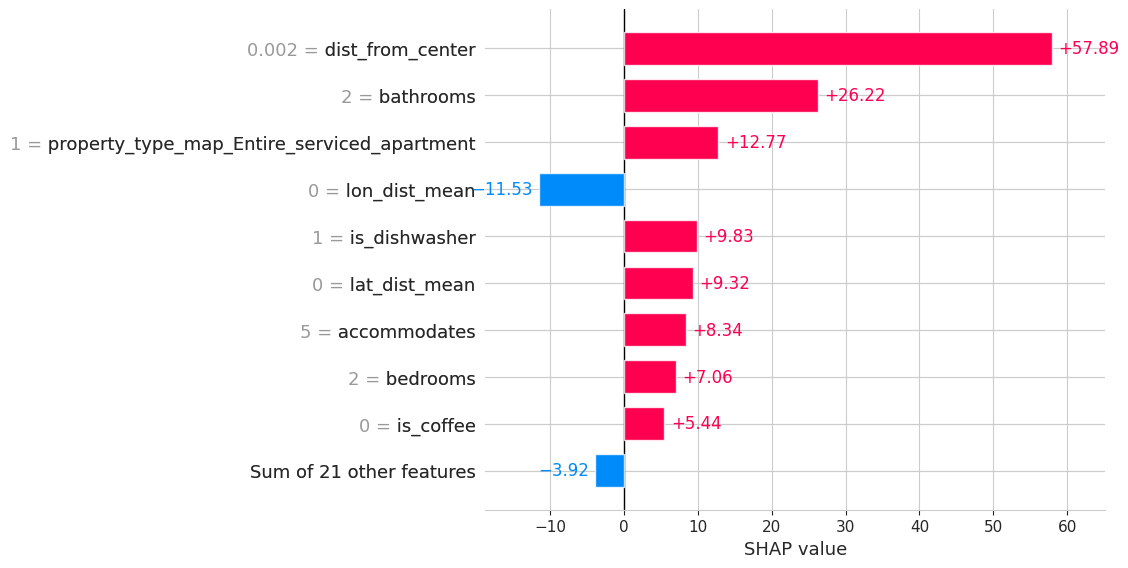

In [ ]:
shap.plots.bar(shap_values[0])

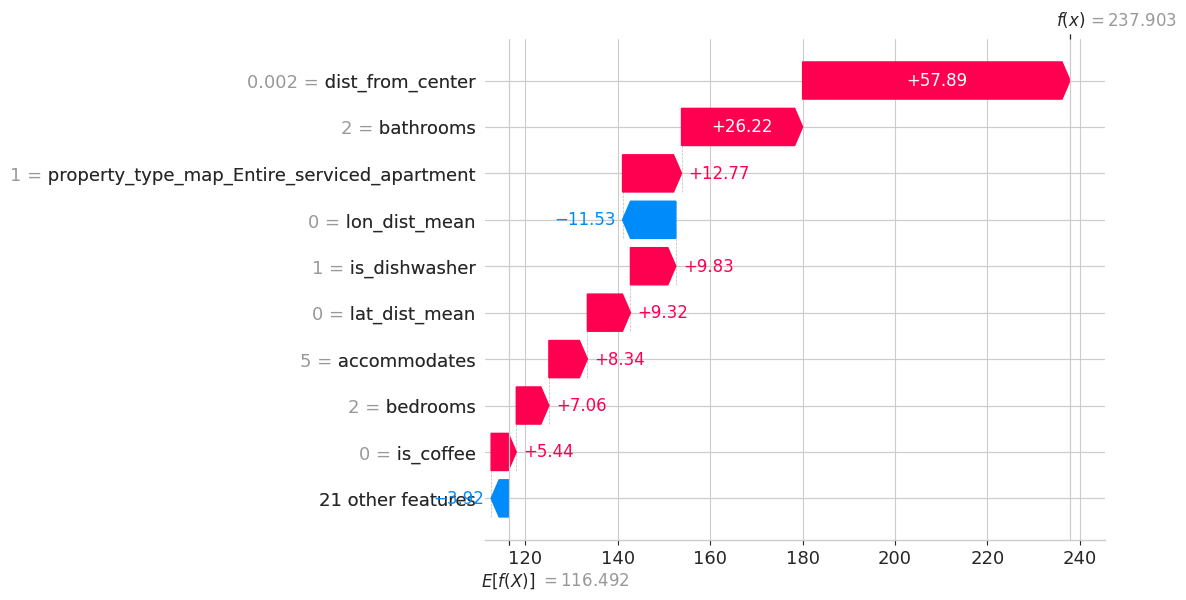

In [ ]:
shap.plots.waterfall(shap_values[0])

Najbardziej typowy przykład: indeks 1661
Predykcja: 108.85, Średnia: 108.77


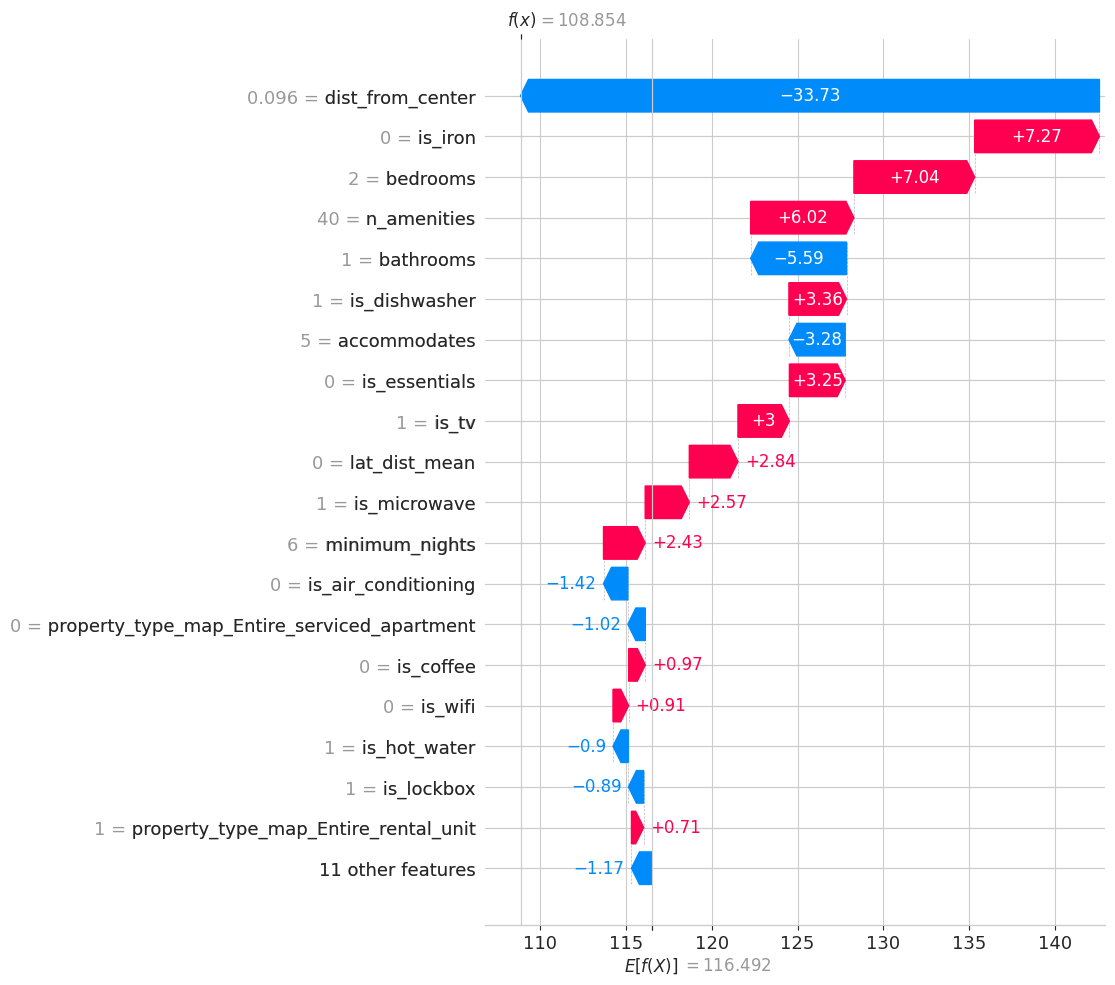

In [ ]:
# Oblicz predykcje dla najbardziej typowego przedstawiciela zbioru
predictions = model.predict(x)

# Znajdź przykład najbliższy średniej predykcji
mean_prediction = predictions.mean()
idx_typical = np.abs(predictions - mean_prediction).argmin()  # argmin zamiast idxmin

print(f"Najbardziej typowy przykład: indeks {idx_typical}")
print(f"Predykcja: {predictions[idx_typical]:.2f}, Średnia: {mean_prediction:.2f}")

# Wyświetl SHAP dla tego przykładu
shap.plots.waterfall(shap_values[idx_typical], max_display=20)

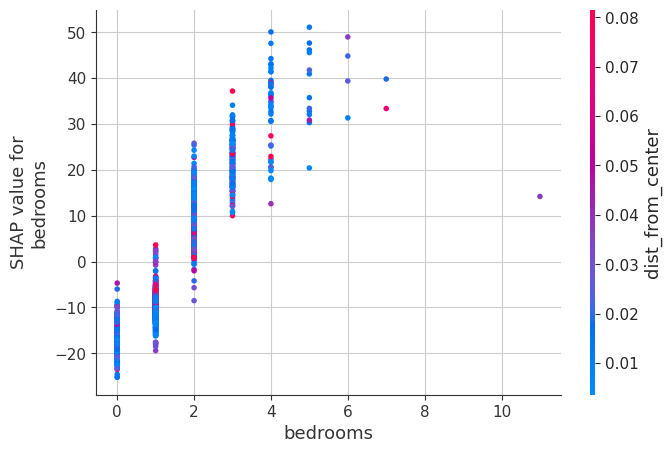

In [ ]:
# Wykres zależności dla wybranej zmiennej
variable_name = 'bedrooms'

shap.dependence_plot(
    variable_name,
    shap_values.values,
    x,
    interaction_index='auto'  # Automatycznie znajdzie najsilniejszą interakcję
)

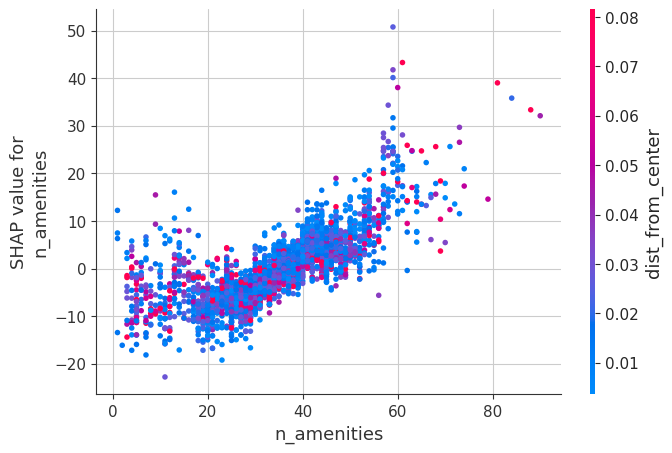

In [ ]:
# Wykres zależności dla wybranej zmiennej
variable_name = 'n_amenities'

shap.dependence_plot(
    variable_name,
    shap_values.values,
    x,
    interaction_index='auto'  # Automatycznie znajdzie najsilniejszą interakcję
)

### Single plot

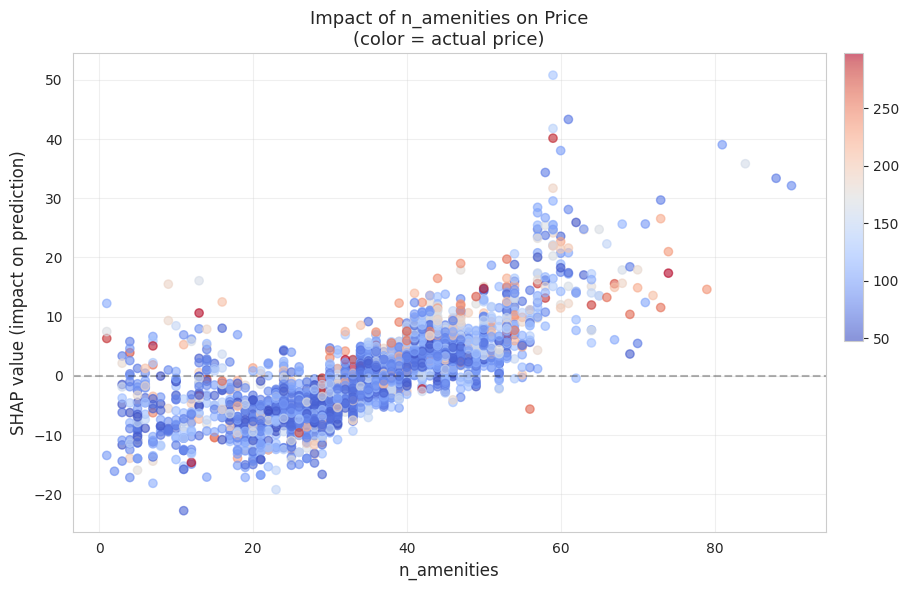

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))  # Dodaj rozmiar rysunku

variable_name = 'n_amenities'
variable_idx = list(x.columns).index(variable_name)

scatter = ax.scatter(  # Zmień axes na ax
    x[variable_name],
    shap_values.values[:, variable_idx],
    c=y,  # Kolor według rzeczywistej ceny
    cmap='coolwarm',
    alpha=0.6
)

# Colorbar - pionowy, zwężony, wyrównany do góry
cbar = fig.colorbar(
    scatter,
    orientation='vertical',
    pad=0.02,           # Odstęp od wykresu
    shrink=0.6,         # Wysokość: 60% wysokości wykresu
    aspect=15,          # Proporcje (wyższe = węższy)
    anchor=(0.0, 1.0)   # Wyrównanie do góry (1.0)
)
# cbar.ax.tick_params(labelsize=7)

# Zmień axes[i] na ax
ax.set_xlabel(variable_name, fontsize=12)
ax.set_ylabel('SHAP value (impact on prediction)', fontsize=12)
ax.set_title(f'Impact of {variable_name} on Price\n(color = actual price)', fontsize=13)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

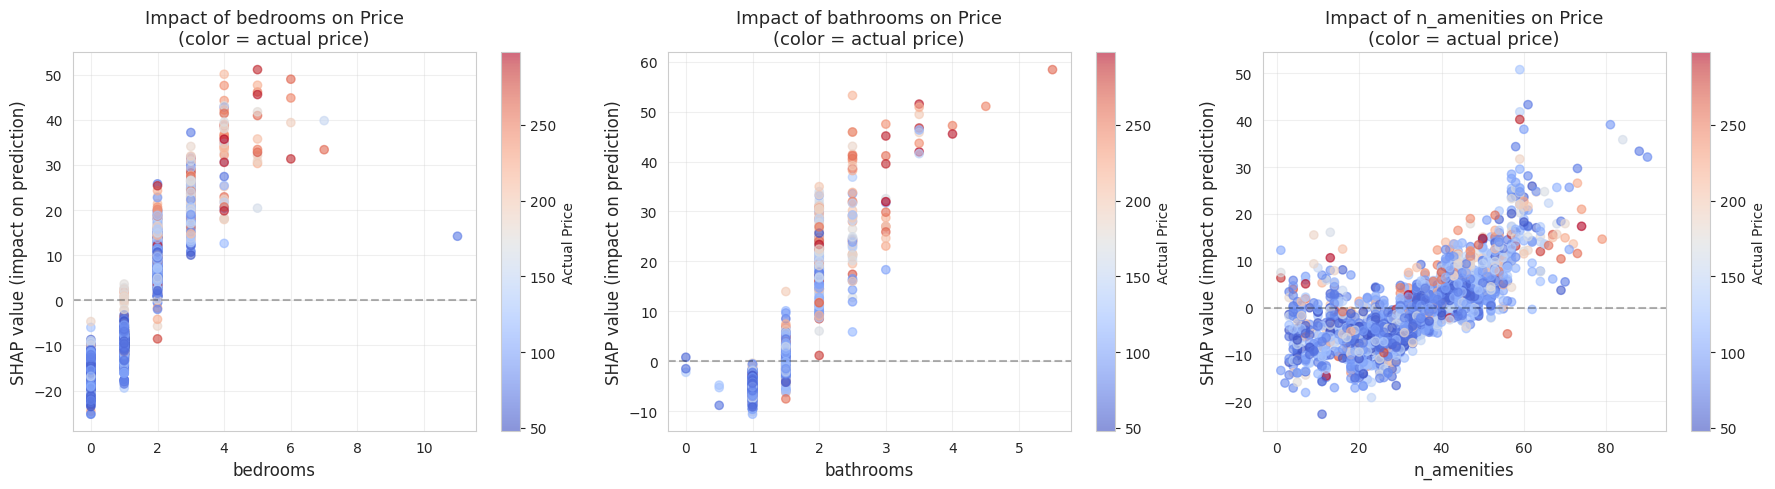

In [ ]:
import matplotlib.pyplot as plt

# Lista zmiennych do analizy
variables_to_plot = ['bedrooms', 'bathrooms', 'n_amenities']

# Stwórz subplot dla każdej zmiennej
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, variable_name in enumerate(variables_to_plot):
    variable_idx = list(x.columns).index(variable_name)

    # Wykres na konkretnym subplot
    scatter = axes[i].scatter(
        x[variable_name],
        shap_values.values[:, variable_idx],
        c=y,  # Kolor według rzeczywistej ceny
        cmap='coolwarm',
        alpha=0.6
    )

    # Colorbar dla każdego wykresu
    plt.colorbar(scatter, ax=axes[i], label='Actual Price')

    axes[i].set_xlabel(variable_name, fontsize=12)
    axes[i].set_ylabel('SHAP value (impact on prediction)', fontsize=12)
    axes[i].set_title(f'Impact of {variable_name} on Price\n(color = actual price)', fontsize=13)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

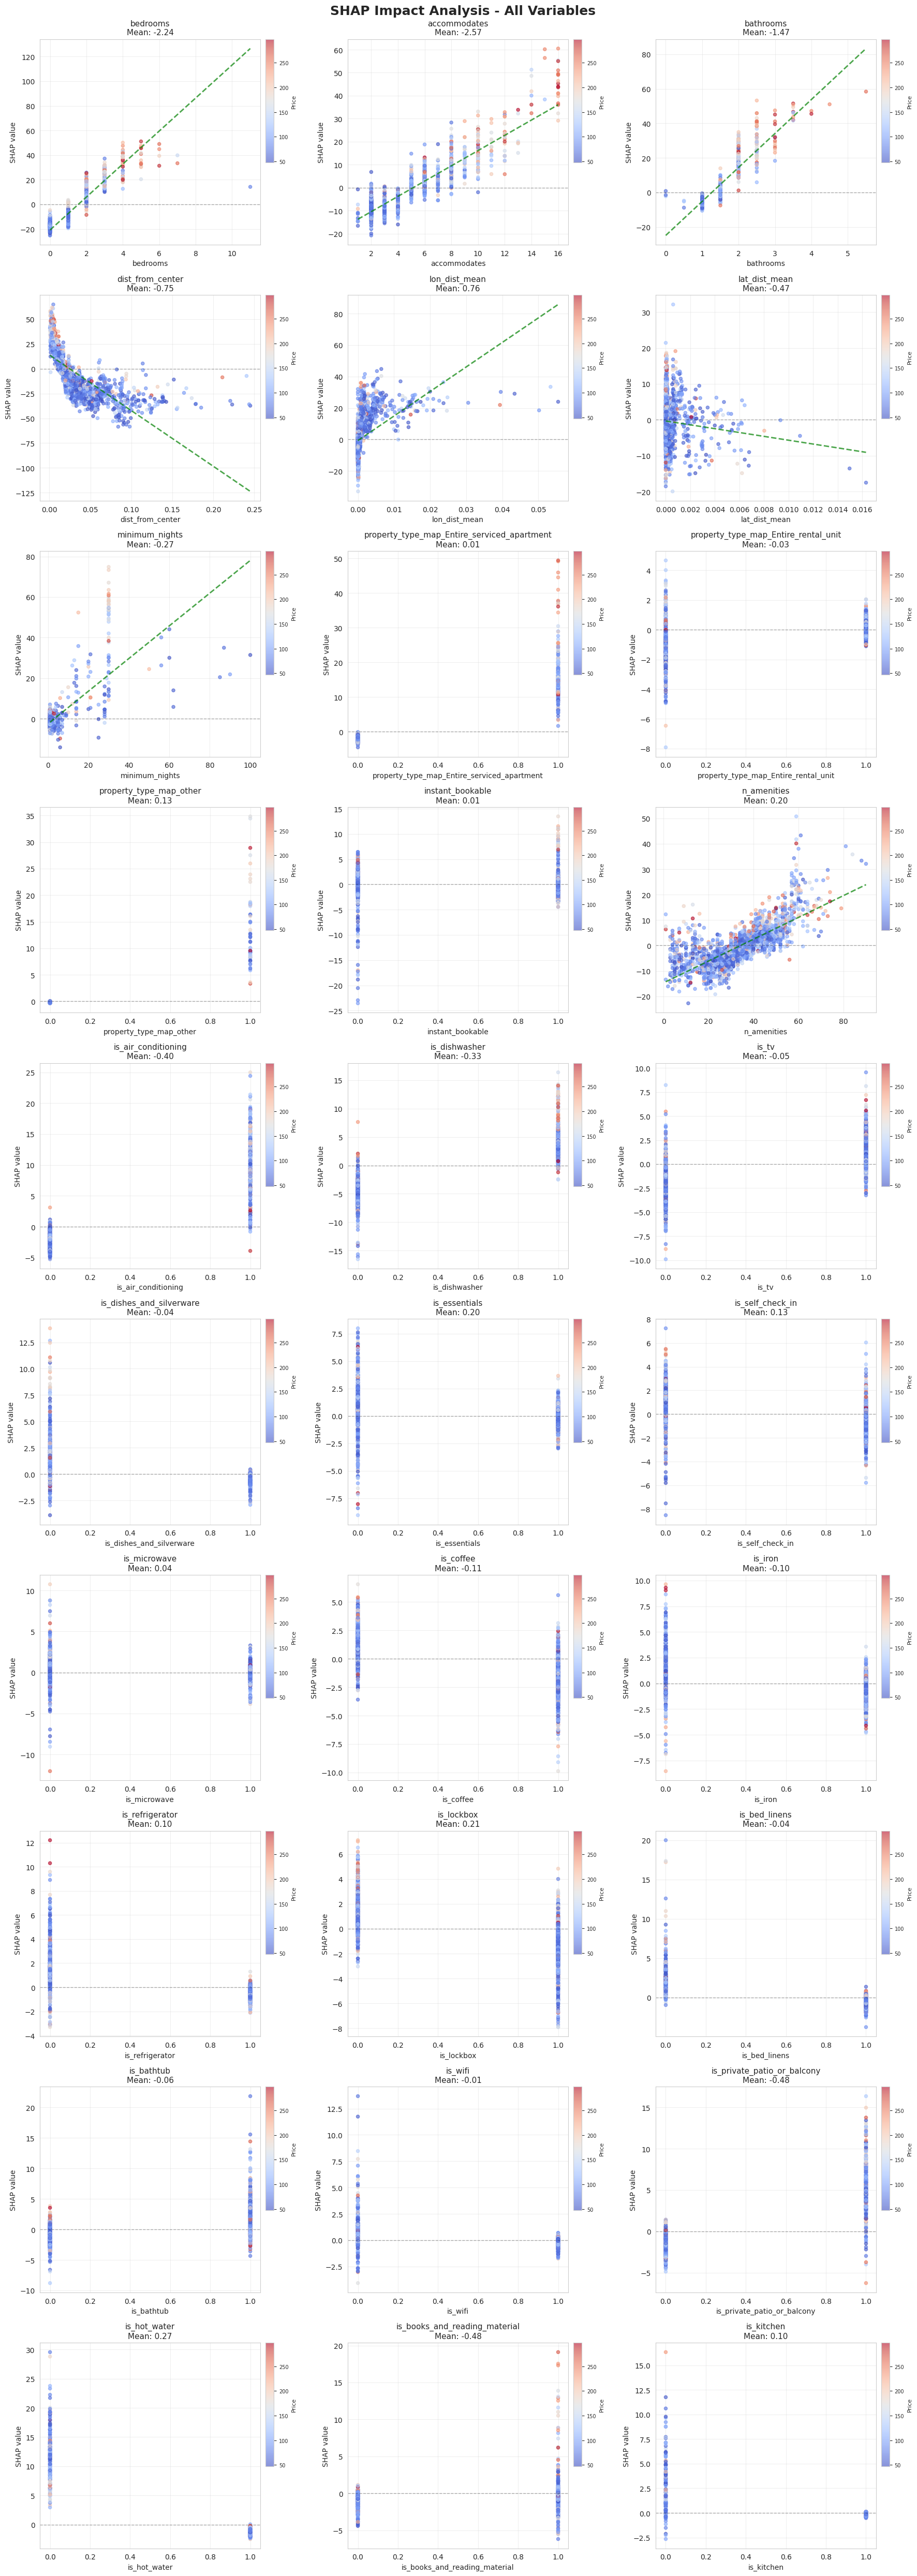

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

variables_to_plot = variables_used

# 3 kolumny
n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, variable_name in enumerate(variables_to_plot):
    variable_idx = list(x.columns).index(variable_name)

    # Dane do wykresu
    x_data = x[variable_name]
    shap_data = shap_values.values[:, variable_idx]

    # Scatter plot
    scatter = axes[i].scatter(
        x_data,
        shap_data,
        c=y,
        cmap='coolwarm',
        alpha=0.6,
        s=20
    )

    # Colorbar - pionowy, zwężony, wyrównany do góry
    cbar = fig.colorbar(
        scatter,
        ax=axes[i],
        orientation='vertical',
        pad=0.02,           # Odstęp od wykresu
        shrink=0.6,         # Wysokość: 60% wysokości wykresu
        aspect=15,          # Proporcje (wyższe = węższy)
        anchor=(0.0, 1.0)   # Wyrównanie do góry (1.0)
    )
    cbar.set_label('Price', fontsize=8)
    cbar.ax.tick_params(labelsize=7)

    # Linia trendu
    if len(np.unique(x_data)) > 2:
        try:
            z = np.polyfit(x_data, shap_data, 1)
            p = np.poly1d(z)
            x_sorted = np.sort(x_data)
            axes[i].plot(x_sorted, p(x_sorted), "g--", linewidth=2, alpha=0.7)
        except:
            pass

    # Formatowanie
    axes[i].set_xlabel(variable_name, fontsize=10)
    axes[i].set_ylabel('SHAP value', fontsize=10)
    axes[i].set_title(f'{variable_name}\nMean: {shap_data.mean():.2f}', fontsize=11)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    axes[i].grid(True, alpha=0.3)

# Usuń puste subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('SHAP Impact Analysis - All Variables', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

!!! to zrobić, pokazać
1 łazienka wpływa pozytywnie o +0.63 na cenę pokoju.
Ocena 93 - zmniejsza cenę o -1.89
2 łóżka - zwiększa cenę o 2.69
Większa liczba recenzji - zwiększa cenę
Liczba gości - 1 gość tylko, to


Generalnie poniższy rysunek - przykład predykcji dla jednego przypadku
- bardzo fajne, żeby zrozumieć dany przypadek, dany model.

E[f(X)] - średnia dla całości, dla całego analizowanego zbioru danych.


Wykres sił.

In [ ]:
#Sources:
#https://www.kaggle.com/yaowenling/berlin-airbnb-data-exploration-public
#https://xavierbourretsicotte.github.io/lasso_implementation.html

### Multiplot ALL

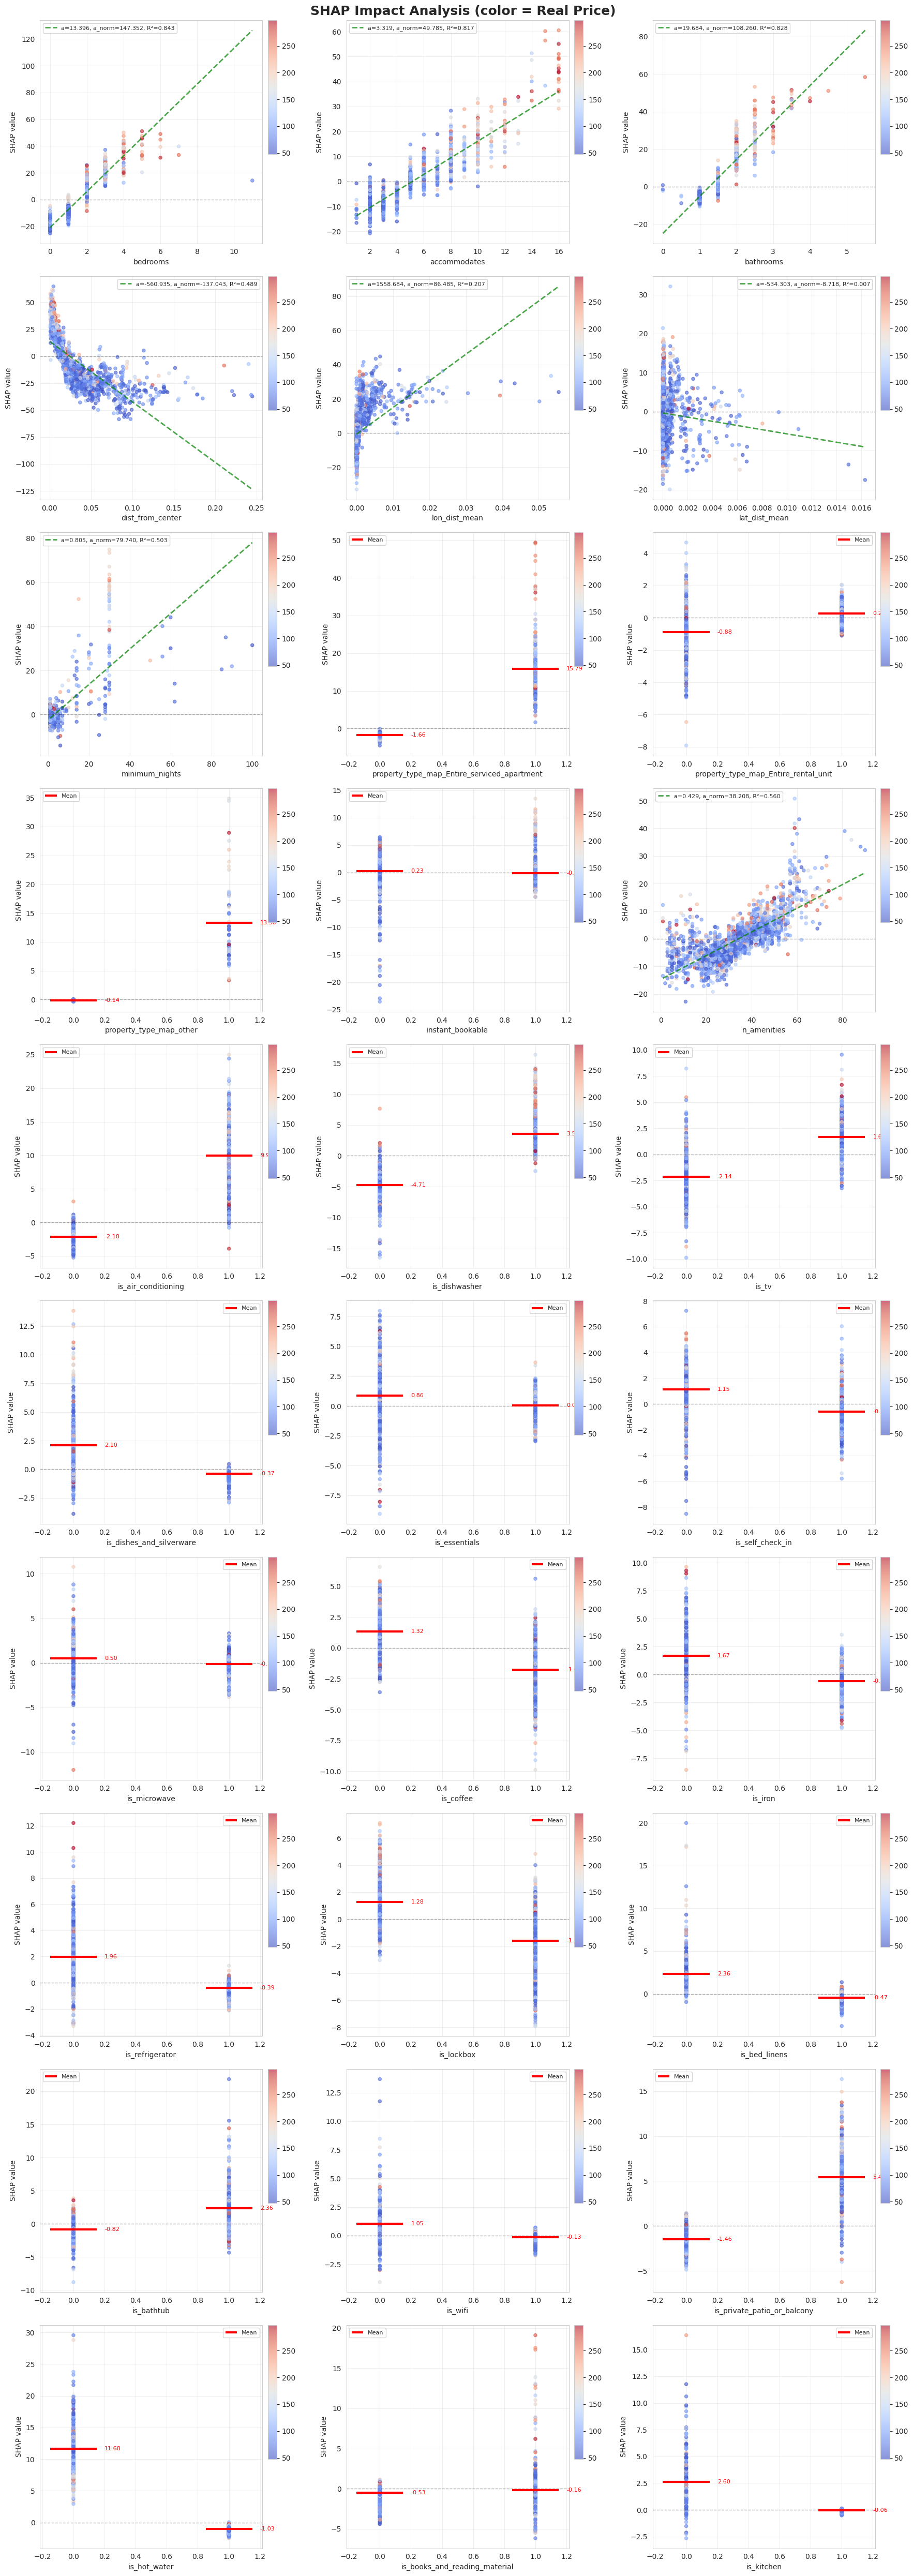


STATYSTYKI DLA ZMIENNYCH DYSKRETNYCH (≤4 wartości)

property_type_map_Entire_serviced_apartment:
  property_type_map_Entire_serviced_apartment=0: SHAP=   -1.66 (n=2587)
  property_type_map_Entire_serviced_apartment=1: SHAP=   15.79 (n=274)
  Różnica (1 vs 0):    17.46

property_type_map_Entire_rental_unit:
  property_type_map_Entire_rental_unit=0: SHAP=   -0.88 (n=742)
  property_type_map_Entire_rental_unit=1: SHAP=    0.27 (n=2119)
  Różnica (1 vs 0):     1.14

property_type_map_other:
  property_type_map_other=0: SHAP=   -0.14 (n=2805)
  property_type_map_other=1: SHAP=   13.30 (n=56)
  Różnica (1 vs 0):    13.44

instant_bookable:
  instant_bookable=0: SHAP=    0.23 (n=1022)
  instant_bookable=1: SHAP=   -0.11 (n=1839)
  Różnica (1 vs 0):    -0.34

is_air_conditioning:
  is_air_conditioning=0: SHAP=   -2.18 (n=2442)
  is_air_conditioning=1: SHAP=    9.95 (n=419)
  Różnica (1 vs 0):    12.13

is_dishwasher:
  is_dishwasher=0: SHAP=   -4.71 (n=1348)
  is_dishwasher=1: SHAP=    3.58 (

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

variables_to_plot = variables_used
n_unique_limit = 4

# 3 kolumny
n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, variable_name in enumerate(variables_to_plot):
    variable_idx = list(x.columns).index(variable_name)

    # Dane do wykresu
    x_data = x[variable_name]
    shap_data = shap_values.values[:, variable_idx]

    # Scatter plot
    scatter = axes[i].scatter(
        x_data,
        shap_data,
        c=y,
        cmap='coolwarm',
        alpha=0.6,
        s=20
    )

    # Colorbar
    cbar = fig.colorbar(
        scatter,
        ax=axes[i],
        orientation='vertical',
        pad=0.02,
        shrink=0.6,
        aspect=15,
        anchor=(0.0, 1.0)
    )

    # Sprawdź czy zmienna dyskretna (mało unikalnych wartości)
    unique_vals = np.unique(x_data)
    n_unique = len(unique_vals)

    if n_unique <= n_unique_limit:  # Zmienna dyskretna
        # Oblicz średnie SHAP dla każdej wartości
        for val in unique_vals:
            mask = x_data == val
            mean_shap = shap_data[mask].mean()

            # Pozioma linia pokazująca średnią
            axes[i].hlines(
                mean_shap,
                val - 0.15,
                val + 0.15,
                colors='red',
                linewidth=3,
                zorder=5,
                label='Mean' if val == unique_vals[0] else ''
            )

            # Tekst ze średnią
            axes[i].text(
                val + 0.2,
                mean_shap,
                f'{mean_shap:.2f}',
                fontsize=8,
                color='red',
                va='center'
            )
    else:  # Zmienna ciągła - linia trendu
        # try:
          # Regresja liniowa
          slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, shap_data)

          # Linia trendu
          x_sorted = np.sort(x_data)
          y_trend = slope * x_sorted + intercept

          # Znormalizowane nachylenie
          x_range = x_data.max() - x_data.min()
          slope_normalized = slope * x_range

          axes[i].plot(
              x_sorted,
              y_trend,
              "g--",
              linewidth=2,
              alpha=0.7,
              label=f'a={slope:.3f}, a_norm={slope_normalized:.3f}, R²={r_value**2:.3f}'
          )

    #         # Dodaj nachylenie i R² do tytułu
    #         axes[i].set_title(
    #             f'{variable_name}\nMean: {shap_data.mean():.2f}, a={slope:.3f}',
    #             fontsize=11
    #         )
    #     except:
    #         axes[i].set_title(f'{variable_name}\nMean: {shap_data.mean():.2f}', fontsize=11)

    # # Formatowanie (jeśli zmienna dyskretna, tytuł bez nachylenia)
    # if n_unique <= n_unique_limit:
    #     axes[i].set_title(f'{variable_name}\nMean: {shap_data.mean():.2f}', fontsize=11)

    axes[i].set_xlabel(variable_name, fontsize=10)
    axes[i].set_ylabel('SHAP value', fontsize=10)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    axes[i].grid(True, alpha=0.3)

    # Legenda
    if n_unique <= n_unique_limit or n_unique > n_unique_limit:
        axes[i].legend(loc='best', fontsize=8)

# Usuń puste subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('SHAP Impact Analysis (color = Real Price)', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statystyki dla zmiennych dyskretnych
print("\n" + "="*80)
print(f"STATYSTYKI DLA ZMIENNYCH DYSKRETNYCH (≤{n_unique_limit} wartości)")
print("="*80)

for variable_name in variables_to_plot:
    variable_idx = list(x.columns).index(variable_name)
    x_data = x[variable_name]
    shap_data = shap_values.values[:, variable_idx]
    unique_vals = np.unique(x_data)

    if len(unique_vals) <= n_unique_limit:  # Dyskretna zmienna
        print(f"\n{variable_name}:")
        for val in unique_vals:
            mask = x_data == val
            mean_shap = shap_data[mask].mean()
            count = mask.sum()
            print(f"  {variable_name}={val}: SHAP={mean_shap:>8.2f} (n={count})")

        # Różnica między wartościami (dla binarnych)
        if len(unique_vals) == 2:
            diff = shap_data[x_data == unique_vals[1]].mean() - shap_data[x_data == unique_vals[0]].mean()
            print(f"  Różnica ({unique_vals[1]} vs {unique_vals[0]}): {diff:>8.2f}")

# Statystyki dla zmiennych ciągłych
print("\n" + "="*80)
print(f"STATYSTYKI DLA ZMIENNYCH CIĄGŁYCH (>{n_unique_limit} wartości)")
print("="*80)

for variable_name in variables_to_plot:
    variable_idx = list(x.columns).index(variable_name)
    x_data = x[variable_name]
    shap_data = shap_values.values[:, variable_idx]
    unique_vals = np.unique(x_data)

    if len(unique_vals) > n_unique_limit:  # Ciągła zmienna
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, shap_data)

            # Dodatkowe statystyki
            x_min = x_data.min()
            x_max = x_data.max()
            x_range = x_max - x_min

            # Znormalizowane nachylenie (wpływ przejścia przez cały zakres)
            slope_normalized = slope * x_range

            print(f"\n{variable_name}:")
            print(f"  Nachylenie (a):              {slope:>10.4f}")
            print(f"  Przecięcie (b):              {intercept:>10.4f}")
            print(f"  R²:                          {r_value**2:>10.4f}")
            print(f"  Znormalizowane (a×range):    {slope_normalized:>10.4f}")
            print(f"  p-value:                     {p_value:>10.4e}")
            print(f"  Std error:                   {std_err:>10.4f}")
            print(f"  Feature min:                 {x_min:>10.4f}")
            print(f"  Feature max:                 {x_max:>10.4f}")
            print(f"  Feature range:               {x_range:>10.4f}")
            print(f"  Interpretacja:")
            print(f"    - 1 jednostka wzrostu → {slope:.4f} zmiana SHAP")
            print(f"    - Przejście min→max → {slope_normalized:.4f} zmiana SHAP")
            print(f"  ---------------------------------------")
        except:
            print(f"\n{variable_name}: Błąd w obliczeniu regresji")

### Multiplot ALL - Reversed

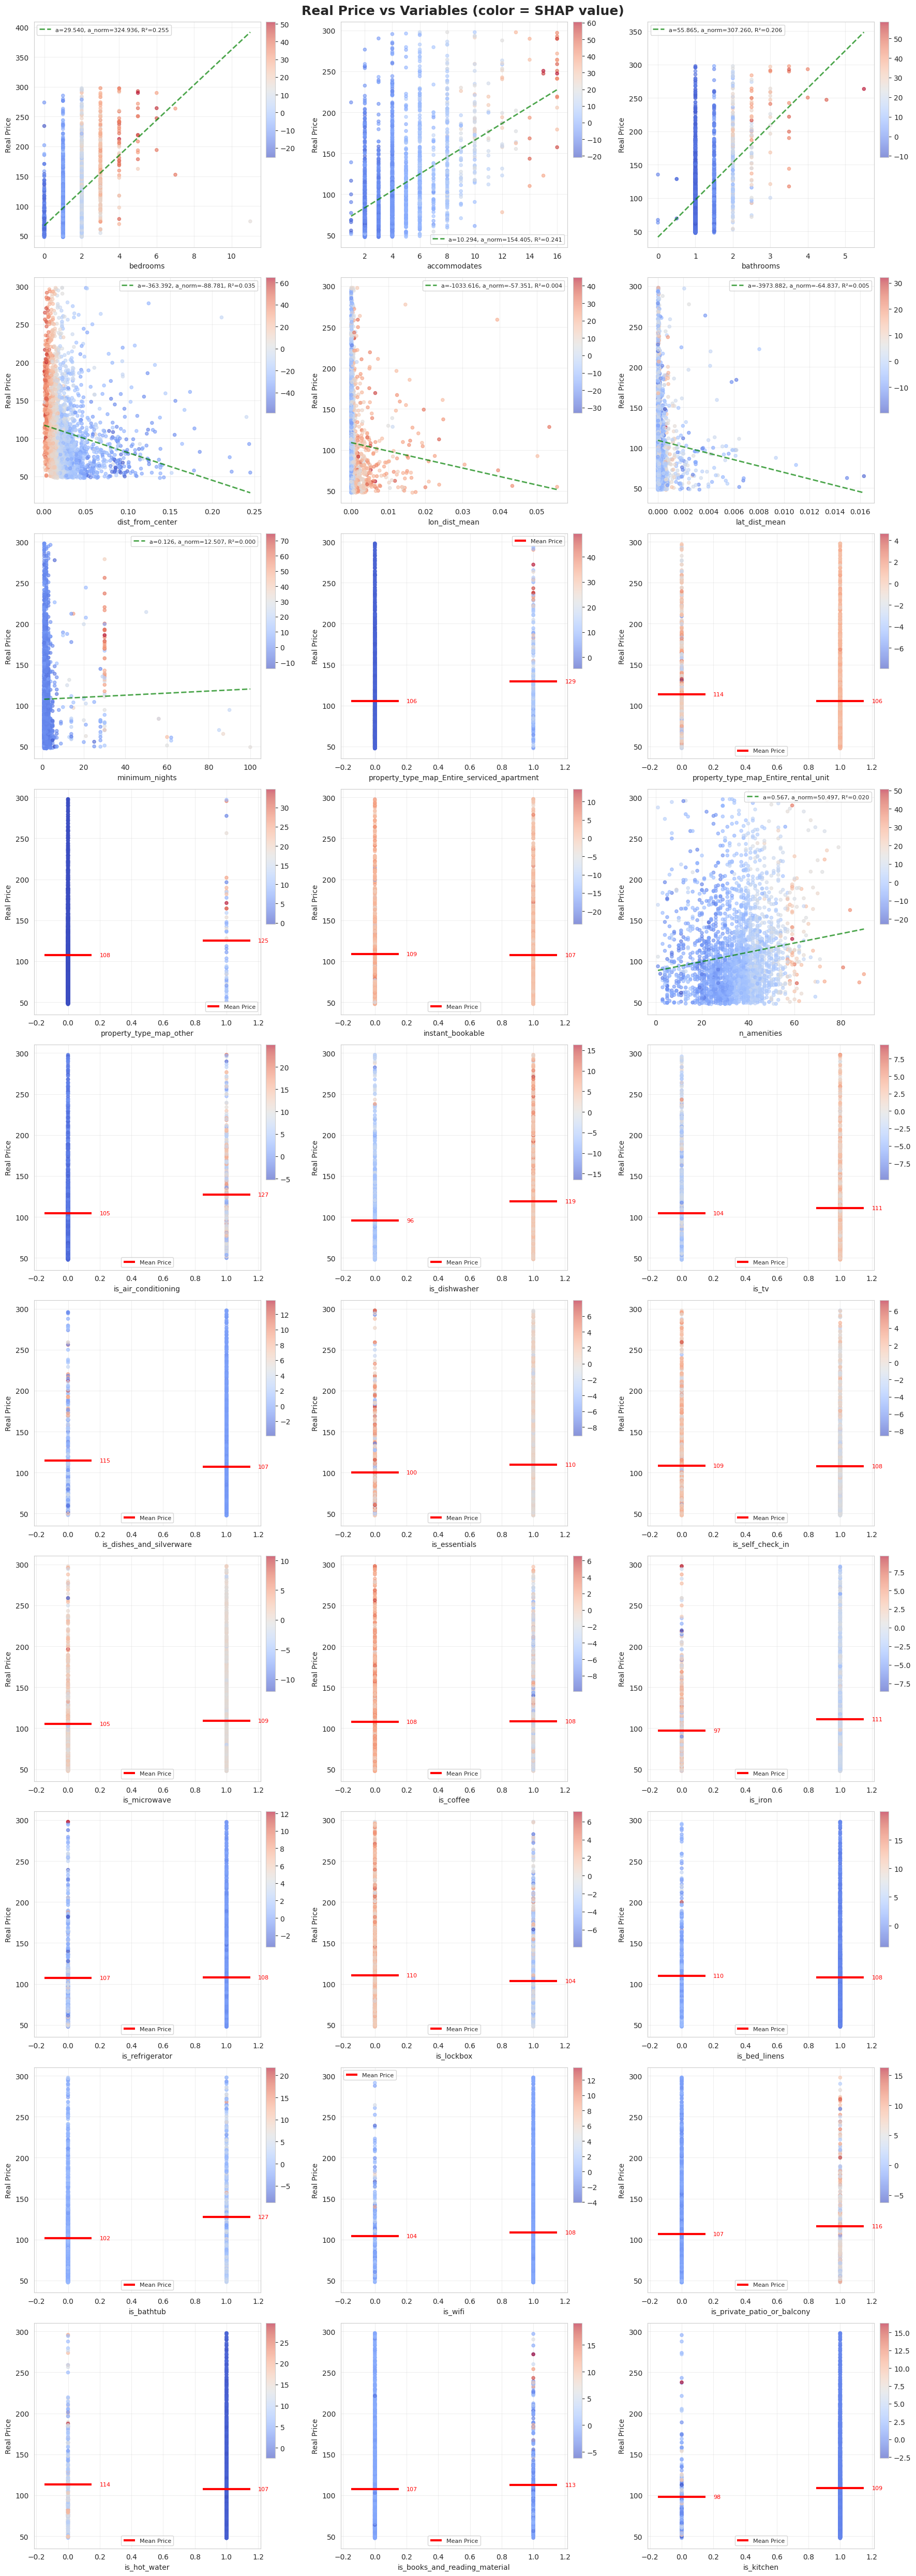


STATYSTYKI DLA ZMIENNYCH DYSKRETNYCH - REAL PRICE

property_type_map_Entire_serviced_apartment:
  property_type_map_Entire_serviced_apartment=0: Mean Price=     106 (n=2587)
  property_type_map_Entire_serviced_apartment=1: Mean Price=     129 (n=274)
  Różnica cen (1 vs 0):       24

property_type_map_Entire_rental_unit:
  property_type_map_Entire_rental_unit=0: Mean Price=     114 (n=742)
  property_type_map_Entire_rental_unit=1: Mean Price=     106 (n=2119)
  Różnica cen (1 vs 0):       -8

property_type_map_other:
  property_type_map_other=0: Mean Price=     108 (n=2805)
  property_type_map_other=1: Mean Price=     125 (n=56)
  Różnica cen (1 vs 0):       18

instant_bookable:
  instant_bookable=0: Mean Price=     109 (n=1022)
  instant_bookable=1: Mean Price=     107 (n=1839)
  Różnica cen (1 vs 0):       -1

is_air_conditioning:
  is_air_conditioning=0: Mean Price=     105 (n=2442)
  is_air_conditioning=1: Mean Price=     127 (n=419)
  Różnica cen (1 vs 0):       22

is_dishwashe

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

variables_to_plot = variables_used
n_unique_limit = 4

# 3 kolumny
n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, variable_name in enumerate(variables_to_plot):
    variable_idx = list(x.columns).index(variable_name)

    # Dane do wykresu
    x_data = x[variable_name]
    shap_data = shap_values.values[:, variable_idx]
    y_data = y  # Real price

    # Scatter plot - ODWRÓCONY: oś Y = Real Price, kolor = SHAP
    scatter = axes[i].scatter(
        x_data,           # x: zmienna
        y_data,           # y: Real Price (było: shap_data)
        c=shap_data,      # kolor: SHAP value (było: y)
        cmap='coolwarm',
        alpha=0.6,
        s=20
    )

    # Colorbar
    cbar = fig.colorbar(
        scatter,
        ax=axes[i],
        orientation='vertical',
        pad=0.02,
        shrink=0.6,
        aspect=15,
        anchor=(0.0, 1.0)
    )
    # cbar.set_label('SHAP value', fontsize=8)
    # cbar.ax.tick_params(labelsize=7)

    # Sprawdź czy zmienna dyskretna (mało unikalnych wartości)
    unique_vals = np.unique(x_data)
    n_unique = len(unique_vals)

    if n_unique <= n_unique_limit:  # Zmienna dyskretna
        # Oblicz średnie Real Price dla każdej wartości
        for val in unique_vals:
            mask = x_data == val
            mean_price = y_data[mask].mean()

            # Pozioma linia pokazująca średnią cenę
            axes[i].hlines(
                mean_price,
                val - 0.15,
                val + 0.15,
                colors='red',
                linewidth=3,
                zorder=5,
                label='Mean Price' if val == unique_vals[0] else ''
            )

            # Tekst ze średnią
            axes[i].text(
                val + 0.2,
                mean_price,
                f'{mean_price:.0f}',
                fontsize=8,
                color='red',
                va='center'
            )
    else:  # Zmienna ciągła - linia trendu
        # try:
          # Regresja liniowa: Real Price vs zmienna
          slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

          # Linia trendu
          x_sorted = np.sort(x_data)
          y_trend = slope * x_sorted + intercept

          # Znormalizowane nachylenie
          x_range = x_data.max() - x_data.min()
          slope_normalized = slope * x_range

          axes[i].plot(
              x_sorted,
              y_trend,
              "g--",
              linewidth=2,
              alpha=0.7,
              label=f'a={slope:.3f}, a_norm={slope_normalized:.3f}, R²={r_value**2:.3f}'
          )

          # # Dodaj nachylenie i R² do tytułu
          # axes[i].set_title(
          #     f'f'a={slope:.3f}, a_norm={slope_normalized:.3f}, R²={r_value**2:.3f}',
          #     fontsize=11
          # )
        # except:
        #     axes[i].set_title(f'{variable_name}\nMean Price: {y_data.mean():.0f}', fontsize=11)

    # # Formatowanie (jeśli zmienna dyskretna, tytuł bez nachylenia)
    # if n_unique <= n_unique_limit:
    #     axes[i].set_title(f'{variable_name}\nMean Price: {y_data.mean():.0f}', fontsize=11)

    axes[i].set_xlabel(variable_name, fontsize=10)
    axes[i].set_ylabel('Real Price', fontsize=10)  # ZMIENIONE
    axes[i].grid(True, alpha=0.3)

    # Legenda
    if n_unique <= n_unique_limit or n_unique > n_unique_limit:
        axes[i].legend(loc='best', fontsize=8)

# Usuń puste subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Real Price vs Variables (color = SHAP value)', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statystyki dla zmiennych dyskretnych
print("\n" + "="*80)
print("STATYSTYKI DLA ZMIENNYCH DYSKRETNYCH - REAL PRICE")
print("="*80)

for variable_name in variables_to_plot:
    variable_idx = list(x.columns).index(variable_name)
    x_data = x[variable_name]
    y_data = y
    unique_vals = np.unique(x_data)

    if len(unique_vals) <= n_unique_limit:
        print(f"\n{variable_name}:")
        for val in unique_vals:
            mask = x_data == val
            mean_price = y_data[mask].mean()
            count = mask.sum()
            print(f"  {variable_name}={val}: Mean Price={mean_price:>8.0f} (n={count})")

        # Różnica w cenach
        if len(unique_vals) == 2:
            diff = y_data[x_data == unique_vals[1]].mean() - y_data[x_data == unique_vals[0]].mean()
            print(f"  Różnica cen ({unique_vals[1]} vs {unique_vals[0]}): {diff:>8.0f}")

# Statystyki dla zmiennych ciągłych
print("\n" + "="*80)
print("STATYSTYKI DLA ZMIENNYCH CIĄGŁYCH - REAL PRICE vs VARIABLE")
print("="*80)

for variable_name in variables_to_plot:
    variable_idx = list(x.columns).index(variable_name)
    x_data = x[variable_name]
    y_data = y
    unique_vals = np.unique(x_data)

    if len(unique_vals) > n_unique_limit:  # Ciągła zmienna
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

            # Dodatkowe statystyki
            x_min = x_data.min()
            x_max = x_data.max()
            x_range = x_max - x_min

            # Znormalizowane nachylenie (wpływ przejścia przez cały zakres)
            slope_normalized = slope * x_range

            print(f"\n{variable_name}:")
            print(f"  Nachylenie (a):              {slope:>10.4f}")
            print(f"  Przecięcie (b):              {intercept:>10.4f}")
            print(f"  R²:                          {r_value**2:>10.4f}")
            print(f"  Znormalizowane (a×range):    {slope_normalized:>10.4f}")
            print(f"  p-value:                     {p_value:>10.4e}")
            print(f"  Std error:                   {std_err:>10.4f}")
            print(f"  Feature min:                 {x_min:>10.4f}")
            print(f"  Feature max:                 {x_max:>10.4f}")
            print(f"  Feature range:               {x_range:>10.4f}")
            print(f"  Interpretacja:")
            print(f"    - 1 jednostka wzrostu → {slope:.4f} EUR zmiana ceny")
            print(f"    - Przejście min→max → {slope_normalized:.4f} EUR zmiana ceny")
            print(f"  ---------------------------------------")
        except:
            print(f"\n{variable_name}: Błąd w obliczeniu regresji")